## Import necessary python modules

In [1]:
import os
import napari
import tifffile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tkinter as tk
from tkinter import filedialog
import bigfish
import bigfish.plot as plot
import bigfish.stack as stack
import bigfish.detection as detection
import bigfish.multistack as multistack
from pathlib import Path
from copy import deepcopy
from dask.array.image import imread as imr
from bigfish.detection.utils import get_object_radius_pixel
from buildReferenceSpot import buildReferenceSpotFromImages
from runBigfishDetection import getSpotAndClusters, saveSpotsNPZ, reorderZstack

In [2]:
from cellpose import models
from cellpose.utils import remove_edge_masks
from cellpose.io import imread, save_to_png, masks_flows_to_seg


## Specify voxel and object size

In [3]:
voxelRadius = (600, 121, 121)
objectRadius = (600, 150, 150)

In [4]:
from scipy.optimize import curve_fit

def bi_exp(x, a, b, c, d):
    return (a * np.exp(-b * x)) + (c * np.exp(-d * x))

def trip_exp(x, a, b, c, d, e, f):
    return ((a * np.exp(-b * x)) + (c * np.exp(-d * x)) + (e * np.exp(-f * x)))

def getBleachCorrected(stackCell, model='bi'):
    axes = tuple([i for i in range(len(stackCell.shape))])
    I_mean = np.mean(stackCell, axis=axes[1:])
    timePoints = np.arange(stackCell.shape[0])
    
    if model=='bi':
        coeffsExp, _ = curve_fit(bi_exp, timePoints, I_mean, maxfev=50000)
        f_ = np.vectorize(bi_exp)(timePoints, *coeffsExp)
    elif model=='tri':
        coeffsExp, _ = curve_fit(trip_exp, timePoints, I_mean, maxfev=50000)
        f_ = np.vectorize(trip_exp)(timePoints, *coeffsExp)
    
    
    f = f_ / np.max(f_)
    f = f.reshape(-1, 1, 1, 1)
    imagesCorrected = (stackCell / f).astype(np.uint16)

    # calculate r squared
    residuals = I_mean - f_
    ss_res = np.sum(residuals ** 2)
    ss_tot = np.sum((I_mean - np.mean(I_mean)) ** 2)
    r_squared = 1 - (ss_res / ss_tot)
    r_squared_exp = np.array(r_squared)
    return imagesCorrected, r_squared_exp, I_mean

In [5]:
def getImagesAndSpotList(sequenceCell, selectedThreshold, voxelRadius, objectRadius, sampling=10):
    images=[]    
    spots_list=[]
    MaxTimePoint = sequenceCell.shape[0]

    spot_radius_px = detection.get_object_radius_pixel(
        voxel_size_nm=voxelRadius, 
        object_radius_nm=objectRadius, 
        ndim=3)

    for t in range(1,MaxTimePoint,sampling):
        rna = np.array(sequenceCell[t])
        images.append(rna)

        # LoG filter
        rna_log = stack.log_filter(rna, sigma=spot_radius_px)

        # local maximum detection
        mask = detection.local_maximum_detection(rna_log, min_distance=spot_radius_px)

        # thresholding
        threshold = detection.automated_threshold_setting(rna_log, mask)
        spots_, _ = detection.spots_thresholding(rna_log, mask, float(selectedThreshold))
        spots_list.append(spots_)
    n=len(images)
    print("Total number of images : "+str(n))
    return images, spots_list, n

In [6]:
def choose_home_folder():
    root = tk.Tk()
    root.withdraw()  # Hide the main window

    file_path = filedialog.askdirectory(initialdir= "/", title='Please select a directory')  # Open file dialog

    root.destroy()  # Close the tkinter window
    return file_path


def getCellMask(cellNumber, labeldf, maskImageAll):
    cellNumber = int(cellNumber.split('_')[-1])
    labeldf[labeldf['label']==cellNumber]
    x00 = int(np.round(np.array(labeldf[labeldf['label']==cellNumber]['x'])[0]))
    y00 = int(np.round(np.array(labeldf[labeldf['label']==cellNumber]['y'])[0]))
    sizex = mipSequenceCell.shape[1]
    sizey = mipSequenceCell.shape[2]
    nminr_ = x00 - sizex//2
    nmaxr_ = x00 + sizex//2
    nminc_ = y00 - sizey//2
    nmaxc_ = y00 + sizey//2

    bxt = (nminc_, nmaxc_, nmaxc_, nminc_, nminc_)
    byt = (nminr_, nminr_, nmaxr_, nmaxr_, nminr_)

    maskCell = maskImageAll[nminr_:nmaxr_,nminc_:nmaxc_]==maskImageAll[x00, y00]
    maskCell = stack.dilation_filter(maskCell, kernel_shape='disk', kernel_size=3)
    return maskCell

def removeSpots(old_spots_list, maskCell):
    new_spots_list = []
    for i in range(len(old_spots_list)):
        new_spots_list
        mask_in = maskCell[old_spots_list[i][:, 1], old_spots_list[i][:, 2]]
        newSpots = np.array(pd.DataFrame(old_spots_list[i])[mask_in]) 
        new_spots_list.append(newSpots)
        if len(new_spots_list) == len(old_spots_list):
            print('all good')
    return new_spots_list



In [7]:
midentifier = 'cell_'
fidentifier = 'TNF'

In [8]:

baseFolder0 = choose_home_folder()#homeFolder+nameKey+imsQ
print("Chosen home folder:", baseFolder0) # folder containg folder of movies
basefolders = [os.path.join(baseFolder0+'/'+i) for i in os.listdir(baseFolder0) if fidentifier in i and os.path.isdir(os.path.join(baseFolder0,i))]
basefolders.sort()
basefolders

Chosen home folder: /media/rachel/Crucial X81/o1tnf


['/media/rachel/Crucial X81/o1tnf/HeLa_O1_4_mcptdsg_new_1hr_basal_14h_drugTNF_10ng_ml_001_F00',
 '/media/rachel/Crucial X81/o1tnf/HeLa_O1_4_mcptdsg_new_1hr_basal_14h_drugTNF_10ng_ml_001_F01',
 '/media/rachel/Crucial X81/o1tnf/HeLa_O1_4_mcptdsg_new_1hr_basal_14h_drugTNF_10ng_ml_001_F02',
 '/media/rachel/Crucial X81/o1tnf/HeLa_O1_4_mcptdsg_new_1hr_basal_14h_drugTNF_10ng_ml_001_F03',
 '/media/rachel/Crucial X81/o1tnf/HeLa_O1_4_mcptdsg_new_1hr_basal_14h_drugTNF_10ng_ml_001_F04',
 '/media/rachel/Crucial X81/o1tnf/HeLa_O1_4_mcptdsg_new_1hr_basal_14h_drugTNF_10ng_ml_001_F05',
 '/media/rachel/Crucial X81/o1tnf/HeLa_O1_4_mcptdsg_new_1hr_basal_14h_drugTNF_10ng_ml_001_F06',
 '/media/rachel/Crucial X81/o1tnf/HeLa_O1_4_mcptdsg_new_1hr_basal_14h_drugTNF_10ng_ml_001_F07',
 '/media/rachel/Crucial X81/o1tnf/HeLa_O1_4_mcptdsg_new_1hr_basal_14h_drugTNF_10ng_ml_001_F08',
 '/media/rachel/Crucial X81/o1tnf/HeLa_O1_4_mcptdsg_new_1hr_basal_14h_drugTNF_10ng_ml_001_F09']

## Specify Input and Output folders, identifiers

0
cell number : cell_10
1
cell number : cell_11
2
cell number : cell_12
3
cell number : cell_14
4
cell number : cell_15
5
cell number : cell_16
6
cell number : cell_17
7
cell number : cell_19
8
cell number : cell_2
9
cell number : cell_20
10
cell number : cell_21
11
cell number : cell_22
path_in/out: /media/rachel/Crucial X81/o1tnf/HeLa_O1_4_mcptdsg_new_1hr_basal_14h_drugTNF_10ng_ml_001_F00/cell_22
all good


/home/rachel/anaconda3/envs/bigfishLive/lib/python3.8/site-packages/numpy/lib/npyio.py:696: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  val = np.asanyarray(val)


12
cell number : cell_23
path_in/out: /media/rachel/Crucial X81/o1tnf/HeLa_O1_4_mcptdsg_new_1hr_basal_14h_drugTNF_10ng_ml_001_F00/cell_23
all good


/home/rachel/anaconda3/envs/bigfishLive/lib/python3.8/site-packages/numpy/lib/npyio.py:696: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  val = np.asanyarray(val)


13
cell number : cell_24
path_in/out: /media/rachel/Crucial X81/o1tnf/HeLa_O1_4_mcptdsg_new_1hr_basal_14h_drugTNF_10ng_ml_001_F00/cell_24
all good


/home/rachel/anaconda3/envs/bigfishLive/lib/python3.8/site-packages/numpy/lib/npyio.py:696: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  val = np.asanyarray(val)


14
cell number : cell_25
15
cell number : cell_26
16
cell number : cell_27
path_in/out: /media/rachel/Crucial X81/o1tnf/HeLa_O1_4_mcptdsg_new_1hr_basal_14h_drugTNF_10ng_ml_001_F00/cell_27
all good


/home/rachel/anaconda3/envs/bigfishLive/lib/python3.8/site-packages/numpy/lib/npyio.py:696: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  val = np.asanyarray(val)


17
cell number : cell_28
path_in/out: /media/rachel/Crucial X81/o1tnf/HeLa_O1_4_mcptdsg_new_1hr_basal_14h_drugTNF_10ng_ml_001_F00/cell_28
all good


/home/rachel/anaconda3/envs/bigfishLive/lib/python3.8/site-packages/numpy/lib/npyio.py:696: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  val = np.asanyarray(val)


18
cell number : cell_29
path_in/out: /media/rachel/Crucial X81/o1tnf/HeLa_O1_4_mcptdsg_new_1hr_basal_14h_drugTNF_10ng_ml_001_F00/cell_29
all good


/home/rachel/anaconda3/envs/bigfishLive/lib/python3.8/site-packages/numpy/lib/npyio.py:696: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  val = np.asanyarray(val)


19
cell number : cell_30
20
cell number : cell_31
path_in/out: /media/rachel/Crucial X81/o1tnf/HeLa_O1_4_mcptdsg_new_1hr_basal_14h_drugTNF_10ng_ml_001_F00/cell_31
21
cell number : cell_32
22
cell number : cell_33
path_in/out: /media/rachel/Crucial X81/o1tnf/HeLa_O1_4_mcptdsg_new_1hr_basal_14h_drugTNF_10ng_ml_001_F00/cell_33
23
cell number : cell_34
path_in/out: /media/rachel/Crucial X81/o1tnf/HeLa_O1_4_mcptdsg_new_1hr_basal_14h_drugTNF_10ng_ml_001_F00/cell_34
all good


/home/rachel/anaconda3/envs/bigfishLive/lib/python3.8/site-packages/numpy/lib/npyio.py:696: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  val = np.asanyarray(val)


24
cell number : cell_35
25
cell number : cell_36
path_in/out: /media/rachel/Crucial X81/o1tnf/HeLa_O1_4_mcptdsg_new_1hr_basal_14h_drugTNF_10ng_ml_001_F00/cell_36
all good


/home/rachel/anaconda3/envs/bigfishLive/lib/python3.8/site-packages/numpy/lib/npyio.py:696: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  val = np.asanyarray(val)


26
cell number : cell_37
path_in/out: /media/rachel/Crucial X81/o1tnf/HeLa_O1_4_mcptdsg_new_1hr_basal_14h_drugTNF_10ng_ml_001_F00/cell_37
27
cell number : cell_38
28
cell number : cell_40
path_in/out: /media/rachel/Crucial X81/o1tnf/HeLa_O1_4_mcptdsg_new_1hr_basal_14h_drugTNF_10ng_ml_001_F00/cell_40
29
cell number : cell_41
30
cell number : cell_42
path_in/out: /media/rachel/Crucial X81/o1tnf/HeLa_O1_4_mcptdsg_new_1hr_basal_14h_drugTNF_10ng_ml_001_F00/cell_42
all good


/home/rachel/anaconda3/envs/bigfishLive/lib/python3.8/site-packages/numpy/lib/npyio.py:696: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  val = np.asanyarray(val)


31
cell number : cell_43
32
cell number : cell_44
path_in/out: /media/rachel/Crucial X81/o1tnf/HeLa_O1_4_mcptdsg_new_1hr_basal_14h_drugTNF_10ng_ml_001_F00/cell_44
33
cell number : cell_45
path_in/out: /media/rachel/Crucial X81/o1tnf/HeLa_O1_4_mcptdsg_new_1hr_basal_14h_drugTNF_10ng_ml_001_F00/cell_45
all good


/home/rachel/anaconda3/envs/bigfishLive/lib/python3.8/site-packages/numpy/lib/npyio.py:696: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  val = np.asanyarray(val)


34
cell number : cell_46
35
cell number : cell_47
36
cell number : cell_49
37
cell number : cell_51
38
cell number : cell_53
39
cell number : cell_54
40
cell number : cell_55
path_in/out: /media/rachel/Crucial X81/o1tnf/HeLa_O1_4_mcptdsg_new_1hr_basal_14h_drugTNF_10ng_ml_001_F00/cell_55
all good


/home/rachel/anaconda3/envs/bigfishLive/lib/python3.8/site-packages/numpy/lib/npyio.py:696: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  val = np.asanyarray(val)


41
cell number : cell_6
0
cell number : cell_1
path_in/out: /media/rachel/Crucial X81/o1tnf/HeLa_O1_4_mcptdsg_new_1hr_basal_14h_drugTNF_10ng_ml_001_F01/cell_1
1
cell number : cell_10
path_in/out: /media/rachel/Crucial X81/o1tnf/HeLa_O1_4_mcptdsg_new_1hr_basal_14h_drugTNF_10ng_ml_001_F01/cell_10
all good


/home/rachel/anaconda3/envs/bigfishLive/lib/python3.8/site-packages/numpy/lib/npyio.py:696: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  val = np.asanyarray(val)


2
cell number : cell_11
3
cell number : cell_12
path_in/out: /media/rachel/Crucial X81/o1tnf/HeLa_O1_4_mcptdsg_new_1hr_basal_14h_drugTNF_10ng_ml_001_F01/cell_12
all good


/home/rachel/anaconda3/envs/bigfishLive/lib/python3.8/site-packages/numpy/lib/npyio.py:696: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  val = np.asanyarray(val)


4
cell number : cell_13
5
cell number : cell_14
6
cell number : cell_15
7
cell number : cell_16
8
cell number : cell_17
9
cell number : cell_18
10
cell number : cell_20
11
cell number : cell_21
path_in/out: /media/rachel/Crucial X81/o1tnf/HeLa_O1_4_mcptdsg_new_1hr_basal_14h_drugTNF_10ng_ml_001_F01/cell_21
all good


/home/rachel/anaconda3/envs/bigfishLive/lib/python3.8/site-packages/numpy/lib/npyio.py:696: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  val = np.asanyarray(val)


12
cell number : cell_23
13
cell number : cell_24
14
cell number : cell_27
15
cell number : cell_28
path_in/out: /media/rachel/Crucial X81/o1tnf/HeLa_O1_4_mcptdsg_new_1hr_basal_14h_drugTNF_10ng_ml_001_F01/cell_28
all good


/home/rachel/anaconda3/envs/bigfishLive/lib/python3.8/site-packages/numpy/lib/npyio.py:696: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  val = np.asanyarray(val)
/tmp/ipykernel_35321/2793872927.py:50: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


16
cell number : cell_29
path_in/out: /media/rachel/Crucial X81/o1tnf/HeLa_O1_4_mcptdsg_new_1hr_basal_14h_drugTNF_10ng_ml_001_F01/cell_29
all good


/home/rachel/anaconda3/envs/bigfishLive/lib/python3.8/site-packages/numpy/lib/npyio.py:696: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  val = np.asanyarray(val)


17
cell number : cell_3
18
cell number : cell_30
19
cell number : cell_31
path_in/out: /media/rachel/Crucial X81/o1tnf/HeLa_O1_4_mcptdsg_new_1hr_basal_14h_drugTNF_10ng_ml_001_F01/cell_31
20
cell number : cell_33
21
cell number : cell_34
22
cell number : cell_35
23
cell number : cell_36
path_in/out: /media/rachel/Crucial X81/o1tnf/HeLa_O1_4_mcptdsg_new_1hr_basal_14h_drugTNF_10ng_ml_001_F01/cell_36
24
cell number : cell_37
path_in/out: /media/rachel/Crucial X81/o1tnf/HeLa_O1_4_mcptdsg_new_1hr_basal_14h_drugTNF_10ng_ml_001_F01/cell_37
all good


/home/rachel/anaconda3/envs/bigfishLive/lib/python3.8/site-packages/numpy/lib/npyio.py:696: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  val = np.asanyarray(val)


25
cell number : cell_38
26
cell number : cell_39
27
cell number : cell_4
28
cell number : cell_41
29
cell number : cell_44
30
cell number : cell_45
31
cell number : cell_46
32
cell number : cell_6
33
cell number : cell_7
34
cell number : cell_8
0
cell number : cell_1
1
cell number : cell_10
2
cell number : cell_11
3
cell number : cell_12
4
cell number : cell_13
5
cell number : cell_14
6
cell number : cell_15
7
cell number : cell_16
8
cell number : cell_17
9
cell number : cell_18
10
cell number : cell_19
11
cell number : cell_2
12
cell number : cell_20
13
cell number : cell_21
14
cell number : cell_22
15
cell number : cell_23
16
cell number : cell_24
17
cell number : cell_25
path_in/out: /media/rachel/Crucial X81/o1tnf/HeLa_O1_4_mcptdsg_new_1hr_basal_14h_drugTNF_10ng_ml_001_F02/cell_25
all good


/home/rachel/anaconda3/envs/bigfishLive/lib/python3.8/site-packages/numpy/lib/npyio.py:696: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  val = np.asanyarray(val)


18
cell number : cell_26
19
cell number : cell_27
20
cell number : cell_28
21
cell number : cell_29
22
cell number : cell_3
23
cell number : cell_30
24
cell number : cell_31
25
cell number : cell_32
path_in/out: /media/rachel/Crucial X81/o1tnf/HeLa_O1_4_mcptdsg_new_1hr_basal_14h_drugTNF_10ng_ml_001_F02/cell_32
26
cell number : cell_33
27
cell number : cell_34
path_in/out: /media/rachel/Crucial X81/o1tnf/HeLa_O1_4_mcptdsg_new_1hr_basal_14h_drugTNF_10ng_ml_001_F02/cell_34
all good


/home/rachel/anaconda3/envs/bigfishLive/lib/python3.8/site-packages/numpy/lib/npyio.py:696: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  val = np.asanyarray(val)


28
cell number : cell_35
29
cell number : cell_36
path_in/out: /media/rachel/Crucial X81/o1tnf/HeLa_O1_4_mcptdsg_new_1hr_basal_14h_drugTNF_10ng_ml_001_F02/cell_36
all good


/home/rachel/anaconda3/envs/bigfishLive/lib/python3.8/site-packages/numpy/lib/npyio.py:696: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  val = np.asanyarray(val)


30
cell number : cell_37
31
cell number : cell_38
path_in/out: /media/rachel/Crucial X81/o1tnf/HeLa_O1_4_mcptdsg_new_1hr_basal_14h_drugTNF_10ng_ml_001_F02/cell_38
all good


/home/rachel/anaconda3/envs/bigfishLive/lib/python3.8/site-packages/numpy/lib/npyio.py:696: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  val = np.asanyarray(val)


32
cell number : cell_39
33
cell number : cell_4
34
cell number : cell_40
35
cell number : cell_41
path_in/out: /media/rachel/Crucial X81/o1tnf/HeLa_O1_4_mcptdsg_new_1hr_basal_14h_drugTNF_10ng_ml_001_F02/cell_41
all good


/home/rachel/anaconda3/envs/bigfishLive/lib/python3.8/site-packages/numpy/lib/npyio.py:696: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  val = np.asanyarray(val)


36
cell number : cell_42
37
cell number : cell_43
path_in/out: /media/rachel/Crucial X81/o1tnf/HeLa_O1_4_mcptdsg_new_1hr_basal_14h_drugTNF_10ng_ml_001_F02/cell_43
38
cell number : cell_44
path_in/out: /media/rachel/Crucial X81/o1tnf/HeLa_O1_4_mcptdsg_new_1hr_basal_14h_drugTNF_10ng_ml_001_F02/cell_44
39
cell number : cell_45
40
cell number : cell_46
path_in/out: /media/rachel/Crucial X81/o1tnf/HeLa_O1_4_mcptdsg_new_1hr_basal_14h_drugTNF_10ng_ml_001_F02/cell_46
all good


/home/rachel/anaconda3/envs/bigfishLive/lib/python3.8/site-packages/numpy/lib/npyio.py:696: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  val = np.asanyarray(val)


41
cell number : cell_47
path_in/out: /media/rachel/Crucial X81/o1tnf/HeLa_O1_4_mcptdsg_new_1hr_basal_14h_drugTNF_10ng_ml_001_F02/cell_47
42
cell number : cell_48
43
cell number : cell_49
path_in/out: /media/rachel/Crucial X81/o1tnf/HeLa_O1_4_mcptdsg_new_1hr_basal_14h_drugTNF_10ng_ml_001_F02/cell_49
all good


/home/rachel/anaconda3/envs/bigfishLive/lib/python3.8/site-packages/numpy/lib/npyio.py:696: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  val = np.asanyarray(val)


44
cell number : cell_5
45
cell number : cell_50
46
cell number : cell_51
path_in/out: /media/rachel/Crucial X81/o1tnf/HeLa_O1_4_mcptdsg_new_1hr_basal_14h_drugTNF_10ng_ml_001_F02/cell_51
47
cell number : cell_52
48
cell number : cell_6
49
cell number : cell_7
50
cell number : cell_8
51
cell number : cell_9
0
cell number : cell_1
1
cell number : cell_11
path_in/out: /media/rachel/Crucial X81/o1tnf/HeLa_O1_4_mcptdsg_new_1hr_basal_14h_drugTNF_10ng_ml_001_F03/cell_11
2
cell number : cell_12
3
cell number : cell_13
4
cell number : cell_14
path_in/out: /media/rachel/Crucial X81/o1tnf/HeLa_O1_4_mcptdsg_new_1hr_basal_14h_drugTNF_10ng_ml_001_F03/cell_14
all good


/home/rachel/anaconda3/envs/bigfishLive/lib/python3.8/site-packages/numpy/lib/npyio.py:696: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  val = np.asanyarray(val)


5
cell number : cell_15
6
cell number : cell_16
7
cell number : cell_18
8
cell number : cell_19
9
cell number : cell_20
10
cell number : cell_21
path_in/out: /media/rachel/Crucial X81/o1tnf/HeLa_O1_4_mcptdsg_new_1hr_basal_14h_drugTNF_10ng_ml_001_F03/cell_21
all good


/home/rachel/anaconda3/envs/bigfishLive/lib/python3.8/site-packages/numpy/lib/npyio.py:696: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  val = np.asanyarray(val)


11
cell number : cell_22
12
cell number : cell_23
13
cell number : cell_24
path_in/out: /media/rachel/Crucial X81/o1tnf/HeLa_O1_4_mcptdsg_new_1hr_basal_14h_drugTNF_10ng_ml_001_F03/cell_24
all good


/home/rachel/anaconda3/envs/bigfishLive/lib/python3.8/site-packages/numpy/lib/npyio.py:696: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  val = np.asanyarray(val)


14
cell number : cell_25
15
cell number : cell_26
16
cell number : cell_27
17
cell number : cell_28
path_in/out: /media/rachel/Crucial X81/o1tnf/HeLa_O1_4_mcptdsg_new_1hr_basal_14h_drugTNF_10ng_ml_001_F03/cell_28
all good


/home/rachel/anaconda3/envs/bigfishLive/lib/python3.8/site-packages/numpy/lib/npyio.py:696: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  val = np.asanyarray(val)


18
cell number : cell_29
path_in/out: /media/rachel/Crucial X81/o1tnf/HeLa_O1_4_mcptdsg_new_1hr_basal_14h_drugTNF_10ng_ml_001_F03/cell_29
all good


/home/rachel/anaconda3/envs/bigfishLive/lib/python3.8/site-packages/numpy/lib/npyio.py:696: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  val = np.asanyarray(val)


19
cell number : cell_3
20
cell number : cell_30
path_in/out: /media/rachel/Crucial X81/o1tnf/HeLa_O1_4_mcptdsg_new_1hr_basal_14h_drugTNF_10ng_ml_001_F03/cell_30
all good


/home/rachel/anaconda3/envs/bigfishLive/lib/python3.8/site-packages/numpy/lib/npyio.py:696: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  val = np.asanyarray(val)


21
cell number : cell_31
path_in/out: /media/rachel/Crucial X81/o1tnf/HeLa_O1_4_mcptdsg_new_1hr_basal_14h_drugTNF_10ng_ml_001_F03/cell_31
all good


/home/rachel/anaconda3/envs/bigfishLive/lib/python3.8/site-packages/numpy/lib/npyio.py:696: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  val = np.asanyarray(val)


22
cell number : cell_32
path_in/out: /media/rachel/Crucial X81/o1tnf/HeLa_O1_4_mcptdsg_new_1hr_basal_14h_drugTNF_10ng_ml_001_F03/cell_32
all good


/home/rachel/anaconda3/envs/bigfishLive/lib/python3.8/site-packages/numpy/lib/npyio.py:696: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  val = np.asanyarray(val)


23
cell number : cell_33
path_in/out: /media/rachel/Crucial X81/o1tnf/HeLa_O1_4_mcptdsg_new_1hr_basal_14h_drugTNF_10ng_ml_001_F03/cell_33
all good


/home/rachel/anaconda3/envs/bigfishLive/lib/python3.8/site-packages/numpy/lib/npyio.py:696: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  val = np.asanyarray(val)


24
cell number : cell_34
path_in/out: /media/rachel/Crucial X81/o1tnf/HeLa_O1_4_mcptdsg_new_1hr_basal_14h_drugTNF_10ng_ml_001_F03/cell_34
all good


/home/rachel/anaconda3/envs/bigfishLive/lib/python3.8/site-packages/numpy/lib/npyio.py:696: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  val = np.asanyarray(val)


25
cell number : cell_35
path_in/out: /media/rachel/Crucial X81/o1tnf/HeLa_O1_4_mcptdsg_new_1hr_basal_14h_drugTNF_10ng_ml_001_F03/cell_35
all good


/home/rachel/anaconda3/envs/bigfishLive/lib/python3.8/site-packages/numpy/lib/npyio.py:696: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  val = np.asanyarray(val)


26
cell number : cell_36
27
cell number : cell_37
28
cell number : cell_38
29
cell number : cell_39
30
cell number : cell_4
path_in/out: /media/rachel/Crucial X81/o1tnf/HeLa_O1_4_mcptdsg_new_1hr_basal_14h_drugTNF_10ng_ml_001_F03/cell_4
all good


/home/rachel/anaconda3/envs/bigfishLive/lib/python3.8/site-packages/numpy/lib/npyio.py:696: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  val = np.asanyarray(val)


31
cell number : cell_40
32
cell number : cell_41
33
cell number : cell_42
34
cell number : cell_43
35
cell number : cell_45
36
cell number : cell_46
37
cell number : cell_47
38
cell number : cell_48
39
cell number : cell_49
40
cell number : cell_50
41
cell number : cell_51
42
cell number : cell_52
43
cell number : cell_54
44
cell number : cell_55
45
cell number : cell_57
46
cell number : cell_58
47
cell number : cell_59
48
cell number : cell_6
path_in/out: /media/rachel/Crucial X81/o1tnf/HeLa_O1_4_mcptdsg_new_1hr_basal_14h_drugTNF_10ng_ml_001_F03/cell_6
all good


/home/rachel/anaconda3/envs/bigfishLive/lib/python3.8/site-packages/numpy/lib/npyio.py:696: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  val = np.asanyarray(val)


49
cell number : cell_7
path_in/out: /media/rachel/Crucial X81/o1tnf/HeLa_O1_4_mcptdsg_new_1hr_basal_14h_drugTNF_10ng_ml_001_F03/cell_7
all good


/home/rachel/anaconda3/envs/bigfishLive/lib/python3.8/site-packages/numpy/lib/npyio.py:696: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  val = np.asanyarray(val)


50
cell number : cell_9
path_in/out: /media/rachel/Crucial X81/o1tnf/HeLa_O1_4_mcptdsg_new_1hr_basal_14h_drugTNF_10ng_ml_001_F03/cell_9
0
cell number : cell_1
1
cell number : cell_10
2
cell number : cell_11
3
cell number : cell_12
4
cell number : cell_13
5
cell number : cell_14
6
cell number : cell_15
7
cell number : cell_16
8
cell number : cell_17
path_in/out: /media/rachel/Crucial X81/o1tnf/HeLa_O1_4_mcptdsg_new_1hr_basal_14h_drugTNF_10ng_ml_001_F04/cell_17
9
cell number : cell_18
10
cell number : cell_20
path_in/out: /media/rachel/Crucial X81/o1tnf/HeLa_O1_4_mcptdsg_new_1hr_basal_14h_drugTNF_10ng_ml_001_F04/cell_20
all good


/home/rachel/anaconda3/envs/bigfishLive/lib/python3.8/site-packages/numpy/lib/npyio.py:696: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  val = np.asanyarray(val)


11
cell number : cell_21
12
cell number : cell_24
13
cell number : cell_25
14
cell number : cell_26
path_in/out: /media/rachel/Crucial X81/o1tnf/HeLa_O1_4_mcptdsg_new_1hr_basal_14h_drugTNF_10ng_ml_001_F04/cell_26
15
cell number : cell_27
path_in/out: /media/rachel/Crucial X81/o1tnf/HeLa_O1_4_mcptdsg_new_1hr_basal_14h_drugTNF_10ng_ml_001_F04/cell_27
16
cell number : cell_28
17
cell number : cell_29
18
cell number : cell_30
19
cell number : cell_31
20
cell number : cell_32
path_in/out: /media/rachel/Crucial X81/o1tnf/HeLa_O1_4_mcptdsg_new_1hr_basal_14h_drugTNF_10ng_ml_001_F04/cell_32
all good


/home/rachel/anaconda3/envs/bigfishLive/lib/python3.8/site-packages/numpy/lib/npyio.py:696: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  val = np.asanyarray(val)


21
cell number : cell_33
path_in/out: /media/rachel/Crucial X81/o1tnf/HeLa_O1_4_mcptdsg_new_1hr_basal_14h_drugTNF_10ng_ml_001_F04/cell_33
22
cell number : cell_34
23
cell number : cell_35
24
cell number : cell_37
25
cell number : cell_38
26
cell number : cell_39
27
cell number : cell_4
path_in/out: /media/rachel/Crucial X81/o1tnf/HeLa_O1_4_mcptdsg_new_1hr_basal_14h_drugTNF_10ng_ml_001_F04/cell_4
all good


/home/rachel/anaconda3/envs/bigfishLive/lib/python3.8/site-packages/numpy/lib/npyio.py:696: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  val = np.asanyarray(val)


28
cell number : cell_40
29
cell number : cell_41
30
cell number : cell_5
31
cell number : cell_6
32
cell number : cell_7
33
cell number : cell_8
34
cell number : cell_9
0
cell number : cell_10
path_in/out: /media/rachel/Crucial X81/o1tnf/HeLa_O1_4_mcptdsg_new_1hr_basal_14h_drugTNF_10ng_ml_001_F05/cell_10
all good


/home/rachel/anaconda3/envs/bigfishLive/lib/python3.8/site-packages/numpy/lib/npyio.py:696: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  val = np.asanyarray(val)


1
cell number : cell_11
2
cell number : cell_13
3
cell number : cell_14
path_in/out: /media/rachel/Crucial X81/o1tnf/HeLa_O1_4_mcptdsg_new_1hr_basal_14h_drugTNF_10ng_ml_001_F05/cell_14
all good


/home/rachel/anaconda3/envs/bigfishLive/lib/python3.8/site-packages/numpy/lib/npyio.py:696: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  val = np.asanyarray(val)


4
cell number : cell_18
path_in/out: /media/rachel/Crucial X81/o1tnf/HeLa_O1_4_mcptdsg_new_1hr_basal_14h_drugTNF_10ng_ml_001_F05/cell_18
5
cell number : cell_19
6
cell number : cell_2
7
cell number : cell_20
8
cell number : cell_21
path_in/out: /media/rachel/Crucial X81/o1tnf/HeLa_O1_4_mcptdsg_new_1hr_basal_14h_drugTNF_10ng_ml_001_F05/cell_21
all good


/home/rachel/anaconda3/envs/bigfishLive/lib/python3.8/site-packages/numpy/lib/npyio.py:696: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  val = np.asanyarray(val)


9
cell number : cell_23
10
cell number : cell_24
11
cell number : cell_25
12
cell number : cell_26
13
cell number : cell_27
path_in/out: /media/rachel/Crucial X81/o1tnf/HeLa_O1_4_mcptdsg_new_1hr_basal_14h_drugTNF_10ng_ml_001_F05/cell_27
all good


/home/rachel/anaconda3/envs/bigfishLive/lib/python3.8/site-packages/numpy/lib/npyio.py:696: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  val = np.asanyarray(val)


14
cell number : cell_28
15
cell number : cell_29
16
cell number : cell_30
path_in/out: /media/rachel/Crucial X81/o1tnf/HeLa_O1_4_mcptdsg_new_1hr_basal_14h_drugTNF_10ng_ml_001_F05/cell_30
all good


/home/rachel/anaconda3/envs/bigfishLive/lib/python3.8/site-packages/numpy/lib/npyio.py:696: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  val = np.asanyarray(val)


17
cell number : cell_31
path_in/out: /media/rachel/Crucial X81/o1tnf/HeLa_O1_4_mcptdsg_new_1hr_basal_14h_drugTNF_10ng_ml_001_F05/cell_31
all good


/home/rachel/anaconda3/envs/bigfishLive/lib/python3.8/site-packages/numpy/lib/npyio.py:696: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  val = np.asanyarray(val)


18
cell number : cell_32
19
cell number : cell_33
20
cell number : cell_34
21
cell number : cell_35
22
cell number : cell_36
path_in/out: /media/rachel/Crucial X81/o1tnf/HeLa_O1_4_mcptdsg_new_1hr_basal_14h_drugTNF_10ng_ml_001_F05/cell_36
23
cell number : cell_37
24
cell number : cell_4
25
cell number : cell_40
path_in/out: /media/rachel/Crucial X81/o1tnf/HeLa_O1_4_mcptdsg_new_1hr_basal_14h_drugTNF_10ng_ml_001_F05/cell_40
all good


/home/rachel/anaconda3/envs/bigfishLive/lib/python3.8/site-packages/numpy/lib/npyio.py:696: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  val = np.asanyarray(val)


26
cell number : cell_41
27
cell number : cell_43
28
cell number : cell_5
29
cell number : cell_6
30
cell number : cell_8
31
cell number : cell_9
0
cell number : cell_1
path_in/out: /media/rachel/Crucial X81/o1tnf/HeLa_O1_4_mcptdsg_new_1hr_basal_14h_drugTNF_10ng_ml_001_F06/cell_1
all good


/home/rachel/anaconda3/envs/bigfishLive/lib/python3.8/site-packages/numpy/lib/npyio.py:696: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  val = np.asanyarray(val)


1
cell number : cell_10
path_in/out: /media/rachel/Crucial X81/o1tnf/HeLa_O1_4_mcptdsg_new_1hr_basal_14h_drugTNF_10ng_ml_001_F06/cell_10
all good


/home/rachel/anaconda3/envs/bigfishLive/lib/python3.8/site-packages/numpy/lib/npyio.py:696: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  val = np.asanyarray(val)


2
cell number : cell_11
3
cell number : cell_12
path_in/out: /media/rachel/Crucial X81/o1tnf/HeLa_O1_4_mcptdsg_new_1hr_basal_14h_drugTNF_10ng_ml_001_F06/cell_12
all good


/home/rachel/anaconda3/envs/bigfishLive/lib/python3.8/site-packages/numpy/lib/npyio.py:696: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  val = np.asanyarray(val)


4
cell number : cell_13
path_in/out: /media/rachel/Crucial X81/o1tnf/HeLa_O1_4_mcptdsg_new_1hr_basal_14h_drugTNF_10ng_ml_001_F06/cell_13
5
cell number : cell_14
6
cell number : cell_15
path_in/out: /media/rachel/Crucial X81/o1tnf/HeLa_O1_4_mcptdsg_new_1hr_basal_14h_drugTNF_10ng_ml_001_F06/cell_15
all good


/home/rachel/anaconda3/envs/bigfishLive/lib/python3.8/site-packages/numpy/lib/npyio.py:696: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  val = np.asanyarray(val)


7
cell number : cell_16
8
cell number : cell_17
9
cell number : cell_19
10
cell number : cell_20
11
cell number : cell_22
12
cell number : cell_23
13
cell number : cell_25
14
cell number : cell_26
15
cell number : cell_27
16
cell number : cell_29
17
cell number : cell_3
18
cell number : cell_30
19
cell number : cell_31
20
cell number : cell_33
21
cell number : cell_34
path_in/out: /media/rachel/Crucial X81/o1tnf/HeLa_O1_4_mcptdsg_new_1hr_basal_14h_drugTNF_10ng_ml_001_F06/cell_34
22
cell number : cell_35
23
cell number : cell_36
24
cell number : cell_37
25
cell number : cell_38
path_in/out: /media/rachel/Crucial X81/o1tnf/HeLa_O1_4_mcptdsg_new_1hr_basal_14h_drugTNF_10ng_ml_001_F06/cell_38
all good


/home/rachel/anaconda3/envs/bigfishLive/lib/python3.8/site-packages/numpy/lib/npyio.py:696: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  val = np.asanyarray(val)


26
cell number : cell_39
path_in/out: /media/rachel/Crucial X81/o1tnf/HeLa_O1_4_mcptdsg_new_1hr_basal_14h_drugTNF_10ng_ml_001_F06/cell_39
all good


/home/rachel/anaconda3/envs/bigfishLive/lib/python3.8/site-packages/numpy/lib/npyio.py:696: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  val = np.asanyarray(val)


27
cell number : cell_4
28
cell number : cell_40
path_in/out: /media/rachel/Crucial X81/o1tnf/HeLa_O1_4_mcptdsg_new_1hr_basal_14h_drugTNF_10ng_ml_001_F06/cell_40
all good


/home/rachel/anaconda3/envs/bigfishLive/lib/python3.8/site-packages/numpy/lib/npyio.py:696: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  val = np.asanyarray(val)


29
cell number : cell_41
path_in/out: /media/rachel/Crucial X81/o1tnf/HeLa_O1_4_mcptdsg_new_1hr_basal_14h_drugTNF_10ng_ml_001_F06/cell_41
all good


/home/rachel/anaconda3/envs/bigfishLive/lib/python3.8/site-packages/numpy/lib/npyio.py:696: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  val = np.asanyarray(val)


30
cell number : cell_42
path_in/out: /media/rachel/Crucial X81/o1tnf/HeLa_O1_4_mcptdsg_new_1hr_basal_14h_drugTNF_10ng_ml_001_F06/cell_42
all good


/home/rachel/anaconda3/envs/bigfishLive/lib/python3.8/site-packages/numpy/lib/npyio.py:696: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  val = np.asanyarray(val)


31
cell number : cell_43
path_in/out: /media/rachel/Crucial X81/o1tnf/HeLa_O1_4_mcptdsg_new_1hr_basal_14h_drugTNF_10ng_ml_001_F06/cell_43
all good


/home/rachel/anaconda3/envs/bigfishLive/lib/python3.8/site-packages/numpy/lib/npyio.py:696: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  val = np.asanyarray(val)


32
cell number : cell_44
33
cell number : cell_45
34
cell number : cell_5
35
cell number : cell_6
path_in/out: /media/rachel/Crucial X81/o1tnf/HeLa_O1_4_mcptdsg_new_1hr_basal_14h_drugTNF_10ng_ml_001_F06/cell_6
all good


/home/rachel/anaconda3/envs/bigfishLive/lib/python3.8/site-packages/numpy/lib/npyio.py:696: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  val = np.asanyarray(val)


36
cell number : cell_7
37
cell number : cell_8
0
cell number : cell_10
1
cell number : cell_11
2
cell number : cell_12
3
cell number : cell_13
4
cell number : cell_14
5
cell number : cell_15
path_in/out: /media/rachel/Crucial X81/o1tnf/HeLa_O1_4_mcptdsg_new_1hr_basal_14h_drugTNF_10ng_ml_001_F07/cell_15
all good


/home/rachel/anaconda3/envs/bigfishLive/lib/python3.8/site-packages/numpy/lib/npyio.py:696: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  val = np.asanyarray(val)


6
cell number : cell_16
path_in/out: /media/rachel/Crucial X81/o1tnf/HeLa_O1_4_mcptdsg_new_1hr_basal_14h_drugTNF_10ng_ml_001_F07/cell_16
7
cell number : cell_17
8
cell number : cell_18
path_in/out: /media/rachel/Crucial X81/o1tnf/HeLa_O1_4_mcptdsg_new_1hr_basal_14h_drugTNF_10ng_ml_001_F07/cell_18
all good


/home/rachel/anaconda3/envs/bigfishLive/lib/python3.8/site-packages/numpy/lib/npyio.py:696: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  val = np.asanyarray(val)


9
cell number : cell_2
10
cell number : cell_20
path_in/out: /media/rachel/Crucial X81/o1tnf/HeLa_O1_4_mcptdsg_new_1hr_basal_14h_drugTNF_10ng_ml_001_F07/cell_20
11
cell number : cell_21
path_in/out: /media/rachel/Crucial X81/o1tnf/HeLa_O1_4_mcptdsg_new_1hr_basal_14h_drugTNF_10ng_ml_001_F07/cell_21
12
cell number : cell_22
path_in/out: /media/rachel/Crucial X81/o1tnf/HeLa_O1_4_mcptdsg_new_1hr_basal_14h_drugTNF_10ng_ml_001_F07/cell_22
all good


/home/rachel/anaconda3/envs/bigfishLive/lib/python3.8/site-packages/numpy/lib/npyio.py:696: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  val = np.asanyarray(val)


13
cell number : cell_23
path_in/out: /media/rachel/Crucial X81/o1tnf/HeLa_O1_4_mcptdsg_new_1hr_basal_14h_drugTNF_10ng_ml_001_F07/cell_23
all good


/home/rachel/anaconda3/envs/bigfishLive/lib/python3.8/site-packages/numpy/lib/npyio.py:696: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  val = np.asanyarray(val)


14
cell number : cell_24
15
cell number : cell_25
16
cell number : cell_26
path_in/out: /media/rachel/Crucial X81/o1tnf/HeLa_O1_4_mcptdsg_new_1hr_basal_14h_drugTNF_10ng_ml_001_F07/cell_26
all good


/home/rachel/anaconda3/envs/bigfishLive/lib/python3.8/site-packages/numpy/lib/npyio.py:696: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  val = np.asanyarray(val)


17
cell number : cell_27
path_in/out: /media/rachel/Crucial X81/o1tnf/HeLa_O1_4_mcptdsg_new_1hr_basal_14h_drugTNF_10ng_ml_001_F07/cell_27
18
cell number : cell_28
19
cell number : cell_29
path_in/out: /media/rachel/Crucial X81/o1tnf/HeLa_O1_4_mcptdsg_new_1hr_basal_14h_drugTNF_10ng_ml_001_F07/cell_29
all good


/home/rachel/anaconda3/envs/bigfishLive/lib/python3.8/site-packages/numpy/lib/npyio.py:696: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  val = np.asanyarray(val)


20
cell number : cell_3
21
cell number : cell_31
22
cell number : cell_32
23
cell number : cell_33
24
cell number : cell_34
path_in/out: /media/rachel/Crucial X81/o1tnf/HeLa_O1_4_mcptdsg_new_1hr_basal_14h_drugTNF_10ng_ml_001_F07/cell_34
all good


/home/rachel/anaconda3/envs/bigfishLive/lib/python3.8/site-packages/numpy/lib/npyio.py:696: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  val = np.asanyarray(val)


25
cell number : cell_35
26
cell number : cell_36
27
cell number : cell_37
28
cell number : cell_38
29
cell number : cell_4
30
cell number : cell_5
31
cell number : cell_6
32
cell number : cell_7
33
cell number : cell_8
34
cell number : cell_9
0
cell number : cell_1
1
cell number : cell_10
path_in/out: /media/rachel/Crucial X81/o1tnf/HeLa_O1_4_mcptdsg_new_1hr_basal_14h_drugTNF_10ng_ml_001_F08/cell_10
2
cell number : cell_12
3
cell number : cell_13
4
cell number : cell_14
path_in/out: /media/rachel/Crucial X81/o1tnf/HeLa_O1_4_mcptdsg_new_1hr_basal_14h_drugTNF_10ng_ml_001_F08/cell_14
all good


/home/rachel/anaconda3/envs/bigfishLive/lib/python3.8/site-packages/numpy/lib/npyio.py:696: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  val = np.asanyarray(val)


5
cell number : cell_16
6
cell number : cell_17
7
cell number : cell_18
8
cell number : cell_2
9
cell number : cell_20
path_in/out: /media/rachel/Crucial X81/o1tnf/HeLa_O1_4_mcptdsg_new_1hr_basal_14h_drugTNF_10ng_ml_001_F08/cell_20
10
cell number : cell_21
11
cell number : cell_23
12
cell number : cell_24
path_in/out: /media/rachel/Crucial X81/o1tnf/HeLa_O1_4_mcptdsg_new_1hr_basal_14h_drugTNF_10ng_ml_001_F08/cell_24
13
cell number : cell_26
14
cell number : cell_27
path_in/out: /media/rachel/Crucial X81/o1tnf/HeLa_O1_4_mcptdsg_new_1hr_basal_14h_drugTNF_10ng_ml_001_F08/cell_27
all good


/home/rachel/anaconda3/envs/bigfishLive/lib/python3.8/site-packages/numpy/lib/npyio.py:696: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  val = np.asanyarray(val)


15
cell number : cell_29
path_in/out: /media/rachel/Crucial X81/o1tnf/HeLa_O1_4_mcptdsg_new_1hr_basal_14h_drugTNF_10ng_ml_001_F08/cell_29
16
cell number : cell_3
path_in/out: /media/rachel/Crucial X81/o1tnf/HeLa_O1_4_mcptdsg_new_1hr_basal_14h_drugTNF_10ng_ml_001_F08/cell_3
all good


/home/rachel/anaconda3/envs/bigfishLive/lib/python3.8/site-packages/numpy/lib/npyio.py:696: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  val = np.asanyarray(val)


17
cell number : cell_32
path_in/out: /media/rachel/Crucial X81/o1tnf/HeLa_O1_4_mcptdsg_new_1hr_basal_14h_drugTNF_10ng_ml_001_F08/cell_32
all good


/home/rachel/anaconda3/envs/bigfishLive/lib/python3.8/site-packages/numpy/lib/npyio.py:696: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  val = np.asanyarray(val)


18
cell number : cell_33
19
cell number : cell_34
20
cell number : cell_35
path_in/out: /media/rachel/Crucial X81/o1tnf/HeLa_O1_4_mcptdsg_new_1hr_basal_14h_drugTNF_10ng_ml_001_F08/cell_35
all good


/home/rachel/anaconda3/envs/bigfishLive/lib/python3.8/site-packages/numpy/lib/npyio.py:696: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  val = np.asanyarray(val)


21
cell number : cell_37
path_in/out: /media/rachel/Crucial X81/o1tnf/HeLa_O1_4_mcptdsg_new_1hr_basal_14h_drugTNF_10ng_ml_001_F08/cell_37
all good


/home/rachel/anaconda3/envs/bigfishLive/lib/python3.8/site-packages/numpy/lib/npyio.py:696: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  val = np.asanyarray(val)


22
cell number : cell_38
23
cell number : cell_39
24
cell number : cell_4
25
cell number : cell_40
26
cell number : cell_42
27
cell number : cell_44
28
cell number : cell_45
29
cell number : cell_46
path_in/out: /media/rachel/Crucial X81/o1tnf/HeLa_O1_4_mcptdsg_new_1hr_basal_14h_drugTNF_10ng_ml_001_F08/cell_46
all good


/home/rachel/anaconda3/envs/bigfishLive/lib/python3.8/site-packages/numpy/lib/npyio.py:696: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  val = np.asanyarray(val)


30
cell number : cell_47
path_in/out: /media/rachel/Crucial X81/o1tnf/HeLa_O1_4_mcptdsg_new_1hr_basal_14h_drugTNF_10ng_ml_001_F08/cell_47
all good


/home/rachel/anaconda3/envs/bigfishLive/lib/python3.8/site-packages/numpy/lib/npyio.py:696: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  val = np.asanyarray(val)


31
cell number : cell_48
32
cell number : cell_49
33
cell number : cell_5
path_in/out: /media/rachel/Crucial X81/o1tnf/HeLa_O1_4_mcptdsg_new_1hr_basal_14h_drugTNF_10ng_ml_001_F08/cell_5
all good


/home/rachel/anaconda3/envs/bigfishLive/lib/python3.8/site-packages/numpy/lib/npyio.py:696: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  val = np.asanyarray(val)


34
cell number : cell_50
path_in/out: /media/rachel/Crucial X81/o1tnf/HeLa_O1_4_mcptdsg_new_1hr_basal_14h_drugTNF_10ng_ml_001_F08/cell_50
all good


/home/rachel/anaconda3/envs/bigfishLive/lib/python3.8/site-packages/numpy/lib/npyio.py:696: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  val = np.asanyarray(val)


35
cell number : cell_51
36
cell number : cell_52
path_in/out: /media/rachel/Crucial X81/o1tnf/HeLa_O1_4_mcptdsg_new_1hr_basal_14h_drugTNF_10ng_ml_001_F08/cell_52
37
cell number : cell_53
path_in/out: /media/rachel/Crucial X81/o1tnf/HeLa_O1_4_mcptdsg_new_1hr_basal_14h_drugTNF_10ng_ml_001_F08/cell_53
38
cell number : cell_6
path_in/out: /media/rachel/Crucial X81/o1tnf/HeLa_O1_4_mcptdsg_new_1hr_basal_14h_drugTNF_10ng_ml_001_F08/cell_6
all good


/home/rachel/anaconda3/envs/bigfishLive/lib/python3.8/site-packages/numpy/lib/npyio.py:696: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  val = np.asanyarray(val)


39
cell number : cell_8
40
cell number : cell_9
path_in/out: /media/rachel/Crucial X81/o1tnf/HeLa_O1_4_mcptdsg_new_1hr_basal_14h_drugTNF_10ng_ml_001_F08/cell_9
all good


/home/rachel/anaconda3/envs/bigfishLive/lib/python3.8/site-packages/numpy/lib/npyio.py:696: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  val = np.asanyarray(val)


0
cell number : cell_10
1
cell number : cell_11
path_in/out: /media/rachel/Crucial X81/o1tnf/HeLa_O1_4_mcptdsg_new_1hr_basal_14h_drugTNF_10ng_ml_001_F09/cell_11
all good


/home/rachel/anaconda3/envs/bigfishLive/lib/python3.8/site-packages/numpy/lib/npyio.py:696: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  val = np.asanyarray(val)


2
cell number : cell_13
3
cell number : cell_14
4
cell number : cell_15
5
cell number : cell_16
6
cell number : cell_18
path_in/out: /media/rachel/Crucial X81/o1tnf/HeLa_O1_4_mcptdsg_new_1hr_basal_14h_drugTNF_10ng_ml_001_F09/cell_18
all good


/home/rachel/anaconda3/envs/bigfishLive/lib/python3.8/site-packages/numpy/lib/npyio.py:696: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  val = np.asanyarray(val)


7
cell number : cell_19
path_in/out: /media/rachel/Crucial X81/o1tnf/HeLa_O1_4_mcptdsg_new_1hr_basal_14h_drugTNF_10ng_ml_001_F09/cell_19
all good


/home/rachel/anaconda3/envs/bigfishLive/lib/python3.8/site-packages/numpy/lib/npyio.py:696: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  val = np.asanyarray(val)


8
cell number : cell_2
9
cell number : cell_20
10
cell number : cell_21
11
cell number : cell_22
12
cell number : cell_23
13
cell number : cell_25
path_in/out: /media/rachel/Crucial X81/o1tnf/HeLa_O1_4_mcptdsg_new_1hr_basal_14h_drugTNF_10ng_ml_001_F09/cell_25
all good


/home/rachel/anaconda3/envs/bigfishLive/lib/python3.8/site-packages/numpy/lib/npyio.py:696: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  val = np.asanyarray(val)


14
cell number : cell_26
15
cell number : cell_27
16
cell number : cell_28
path_in/out: /media/rachel/Crucial X81/o1tnf/HeLa_O1_4_mcptdsg_new_1hr_basal_14h_drugTNF_10ng_ml_001_F09/cell_28
17
cell number : cell_29
path_in/out: /media/rachel/Crucial X81/o1tnf/HeLa_O1_4_mcptdsg_new_1hr_basal_14h_drugTNF_10ng_ml_001_F09/cell_29
all good


/home/rachel/anaconda3/envs/bigfishLive/lib/python3.8/site-packages/numpy/lib/npyio.py:696: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  val = np.asanyarray(val)


18
cell number : cell_3
19
cell number : cell_30
20
cell number : cell_31
21
cell number : cell_32
22
cell number : cell_33
23
cell number : cell_34
path_in/out: /media/rachel/Crucial X81/o1tnf/HeLa_O1_4_mcptdsg_new_1hr_basal_14h_drugTNF_10ng_ml_001_F09/cell_34
24
cell number : cell_36
path_in/out: /media/rachel/Crucial X81/o1tnf/HeLa_O1_4_mcptdsg_new_1hr_basal_14h_drugTNF_10ng_ml_001_F09/cell_36
25
cell number : cell_37
26
cell number : cell_38
27
cell number : cell_39
path_in/out: /media/rachel/Crucial X81/o1tnf/HeLa_O1_4_mcptdsg_new_1hr_basal_14h_drugTNF_10ng_ml_001_F09/cell_39
all good


/home/rachel/anaconda3/envs/bigfishLive/lib/python3.8/site-packages/numpy/lib/npyio.py:696: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  val = np.asanyarray(val)


28
cell number : cell_4
29
cell number : cell_40
30
cell number : cell_41
31
cell number : cell_42
path_in/out: /media/rachel/Crucial X81/o1tnf/HeLa_O1_4_mcptdsg_new_1hr_basal_14h_drugTNF_10ng_ml_001_F09/cell_42
all good


/home/rachel/anaconda3/envs/bigfishLive/lib/python3.8/site-packages/numpy/lib/npyio.py:696: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  val = np.asanyarray(val)


32
cell number : cell_43
33
cell number : cell_44
34
cell number : cell_45
35
cell number : cell_46
36
cell number : cell_47
37
cell number : cell_48
path_in/out: /media/rachel/Crucial X81/o1tnf/HeLa_O1_4_mcptdsg_new_1hr_basal_14h_drugTNF_10ng_ml_001_F09/cell_48
38
cell number : cell_49
path_in/out: /media/rachel/Crucial X81/o1tnf/HeLa_O1_4_mcptdsg_new_1hr_basal_14h_drugTNF_10ng_ml_001_F09/cell_49
39
cell number : cell_5
path_in/out: /media/rachel/Crucial X81/o1tnf/HeLa_O1_4_mcptdsg_new_1hr_basal_14h_drugTNF_10ng_ml_001_F09/cell_5
all good


/home/rachel/anaconda3/envs/bigfishLive/lib/python3.8/site-packages/numpy/lib/npyio.py:696: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  val = np.asanyarray(val)


40
cell number : cell_50
41
cell number : cell_51
42
cell number : cell_52
43
cell number : cell_53
path_in/out: /media/rachel/Crucial X81/o1tnf/HeLa_O1_4_mcptdsg_new_1hr_basal_14h_drugTNF_10ng_ml_001_F09/cell_53
44
cell number : cell_54
45
cell number : cell_6
path_in/out: /media/rachel/Crucial X81/o1tnf/HeLa_O1_4_mcptdsg_new_1hr_basal_14h_drugTNF_10ng_ml_001_F09/cell_6
all good


/home/rachel/anaconda3/envs/bigfishLive/lib/python3.8/site-packages/numpy/lib/npyio.py:696: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  val = np.asanyarray(val)


46
cell number : cell_7
47
cell number : cell_8


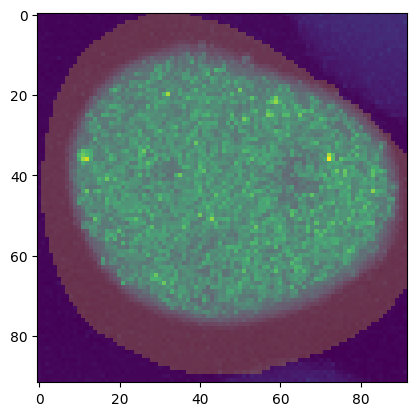

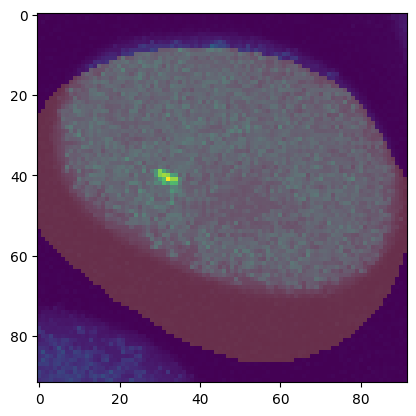

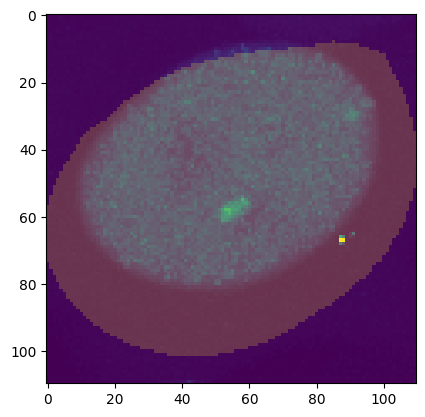

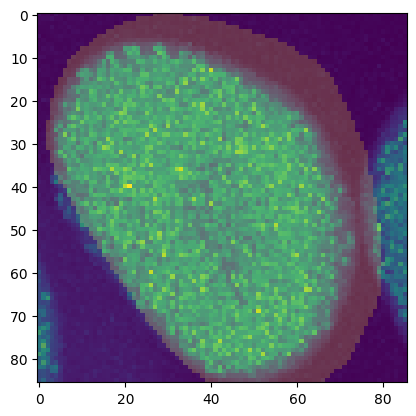

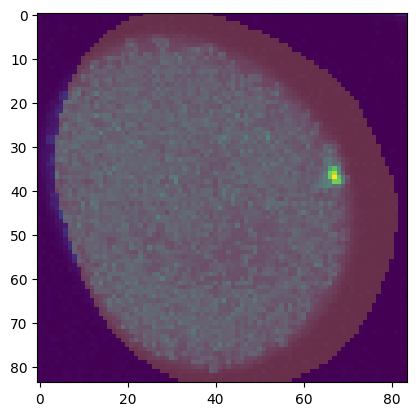

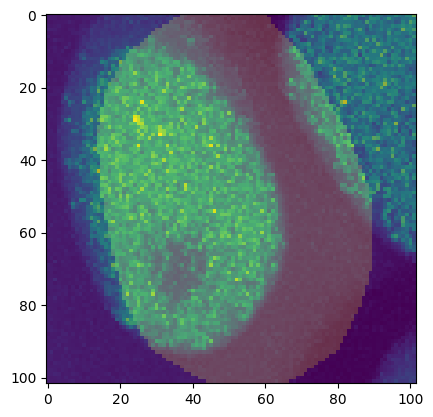

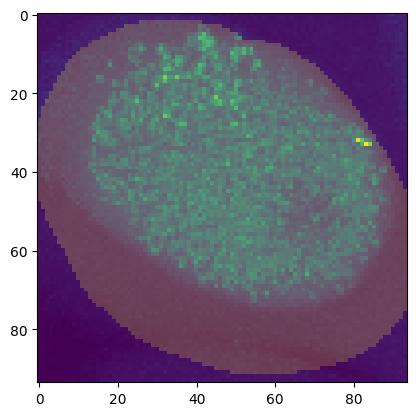

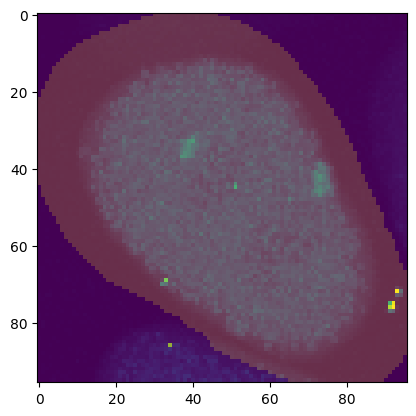

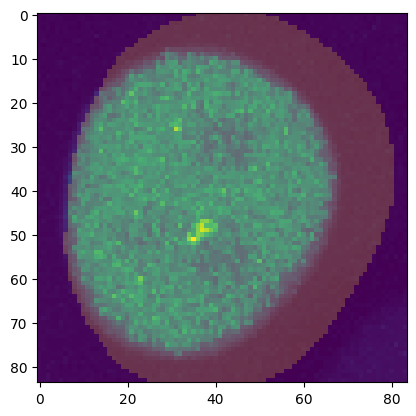

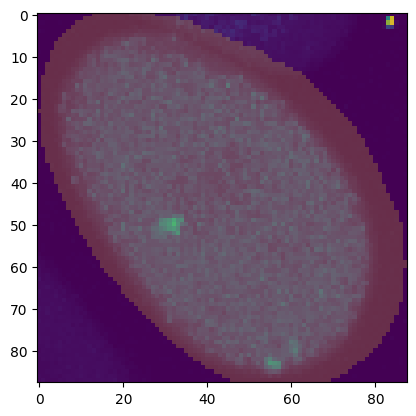

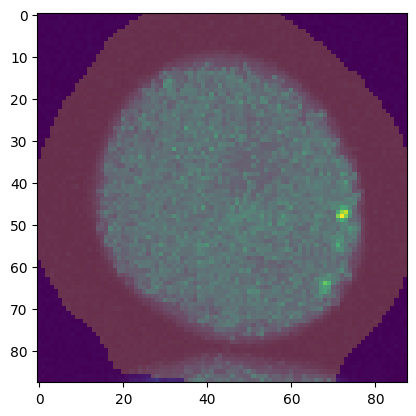

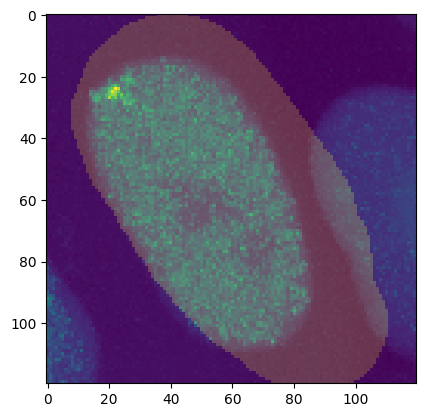

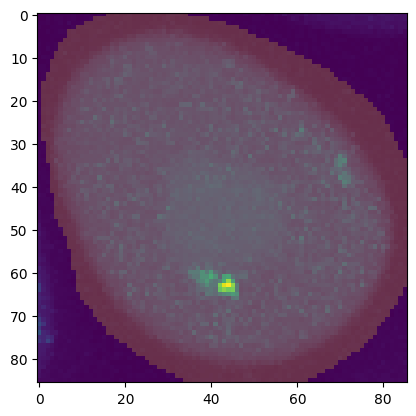

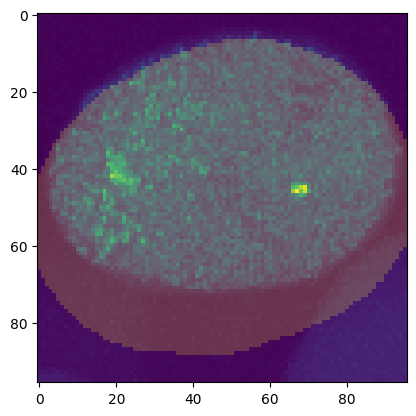

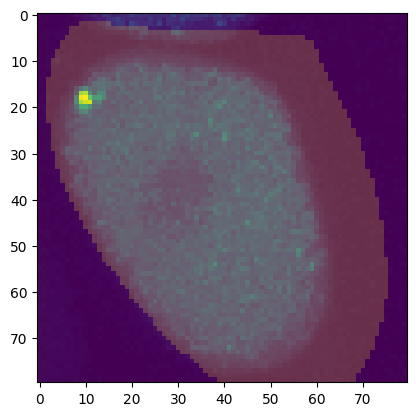

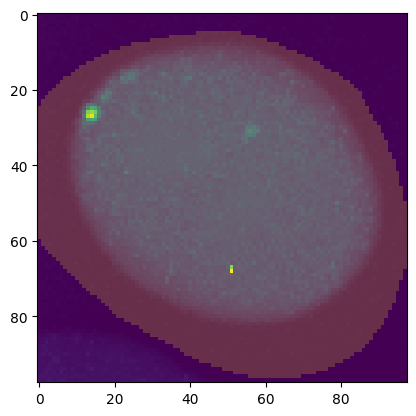

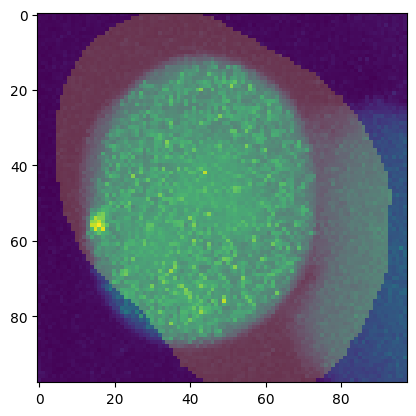

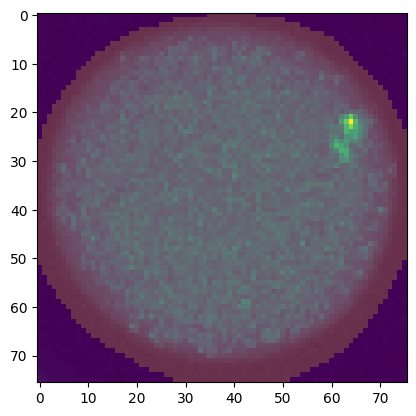

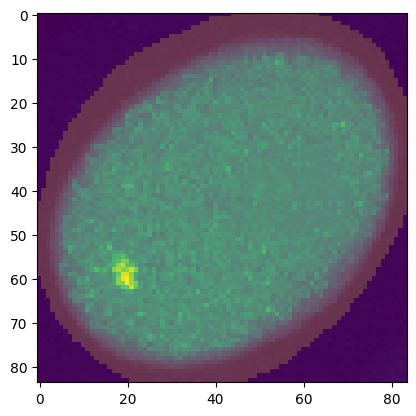

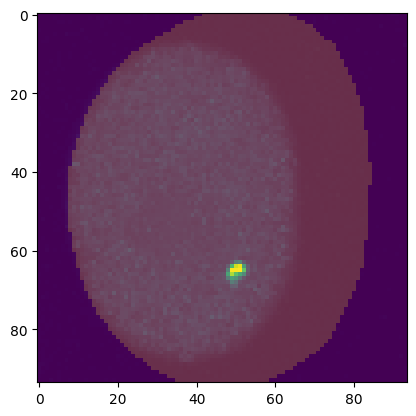

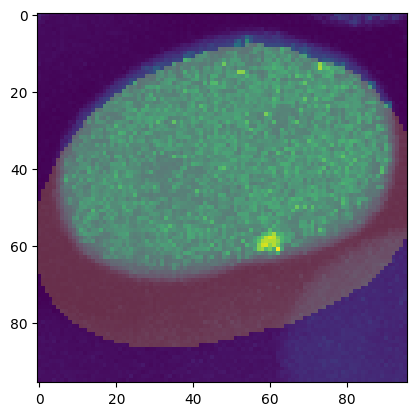

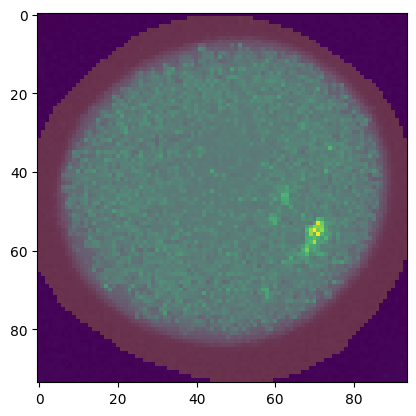

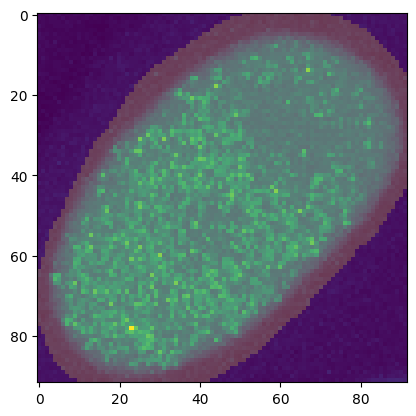

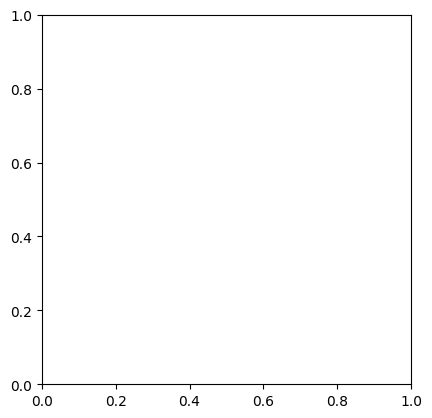

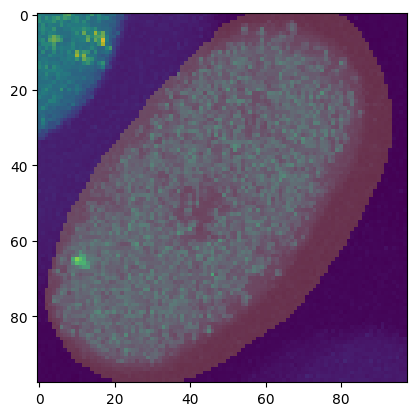

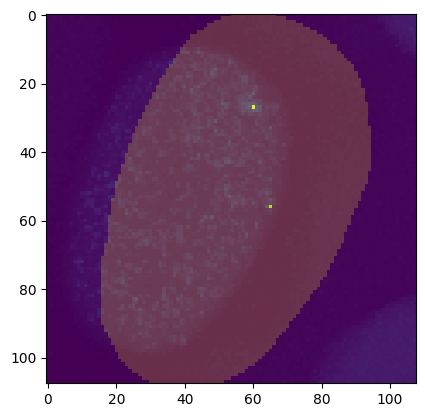

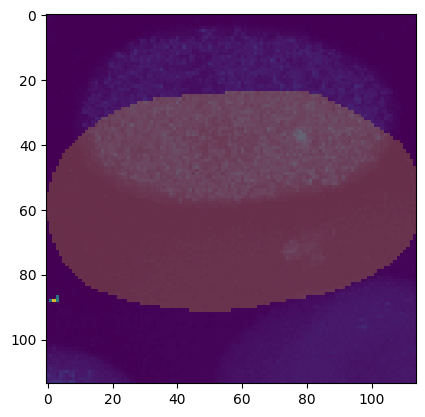

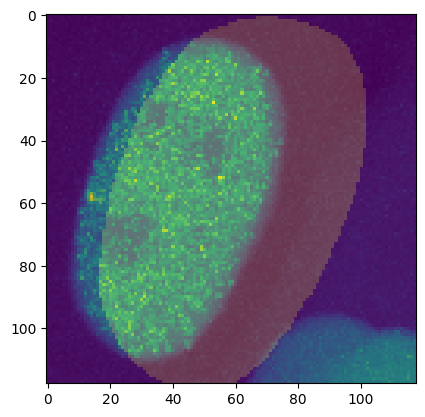

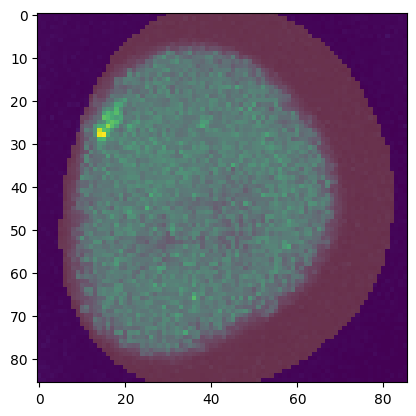

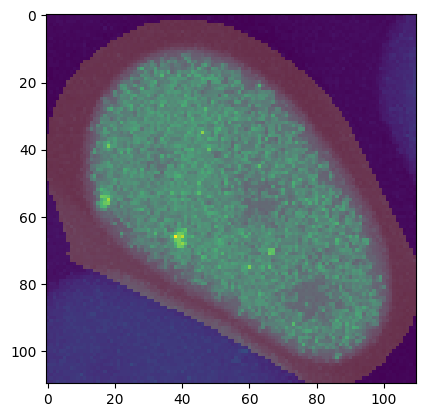

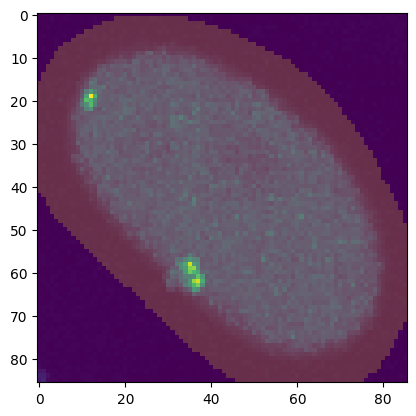

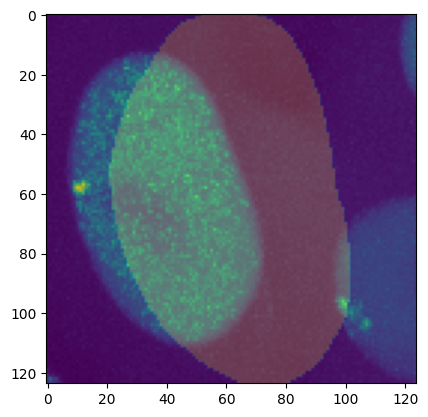

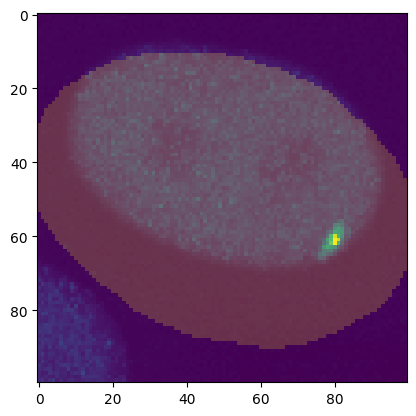

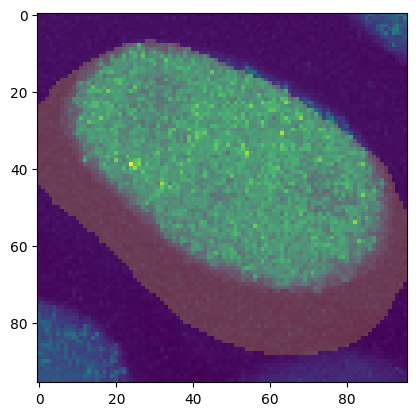

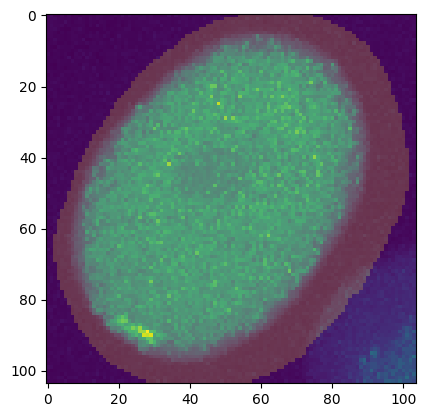

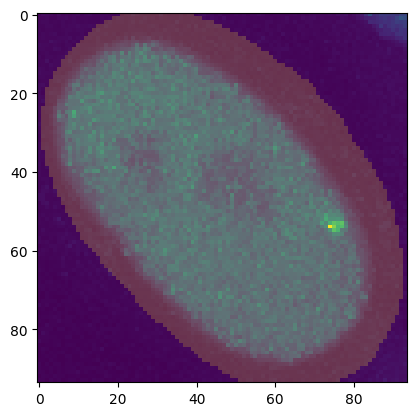

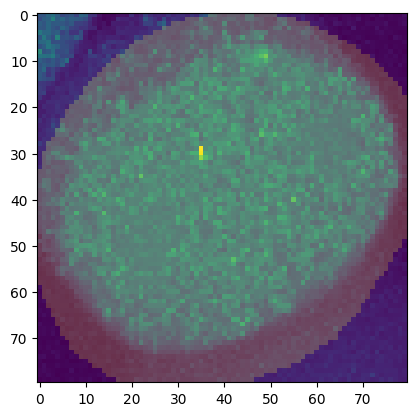

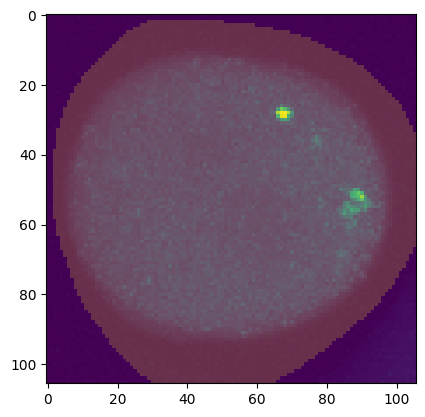

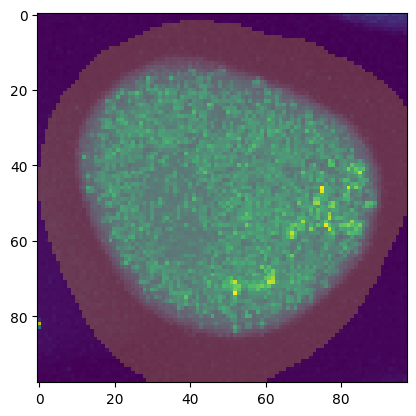

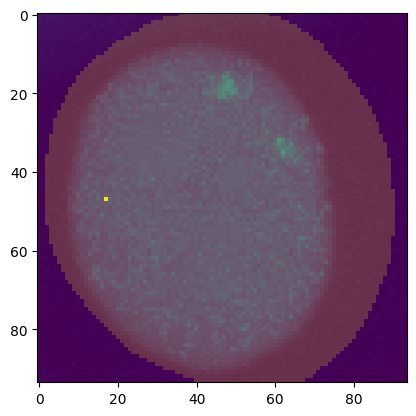

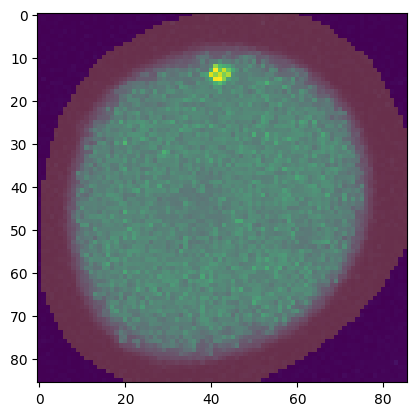

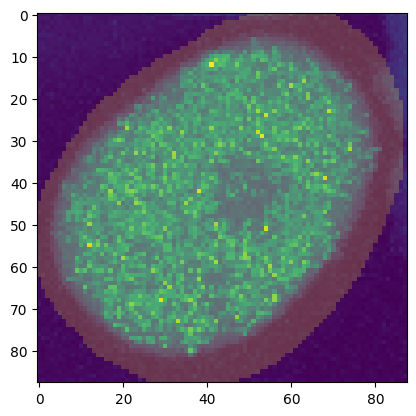

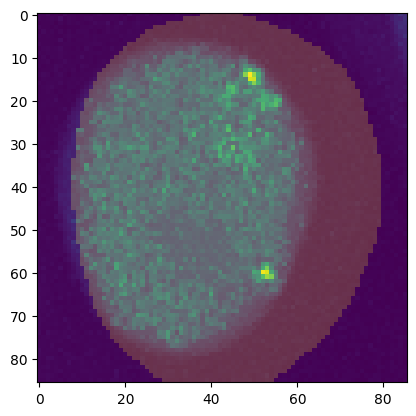

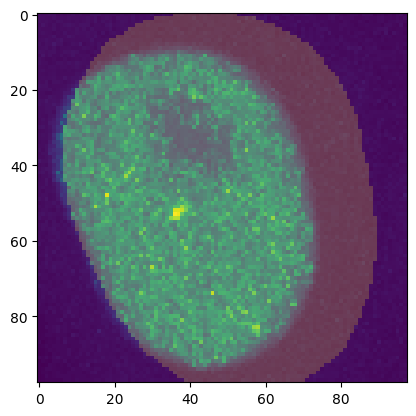

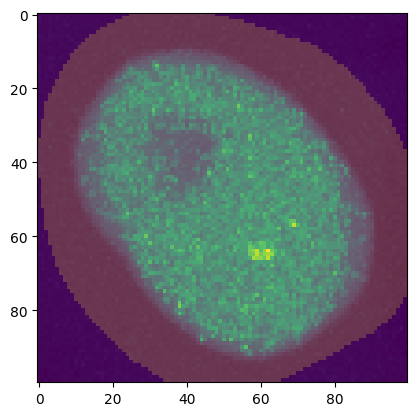

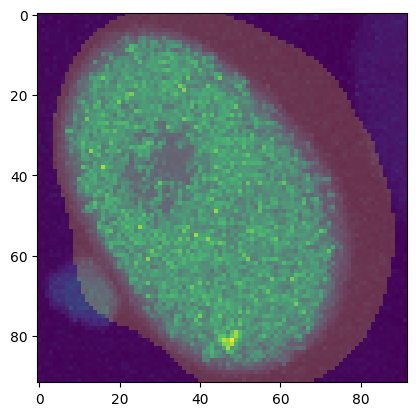

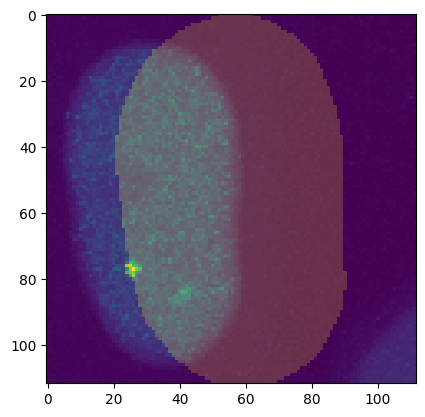

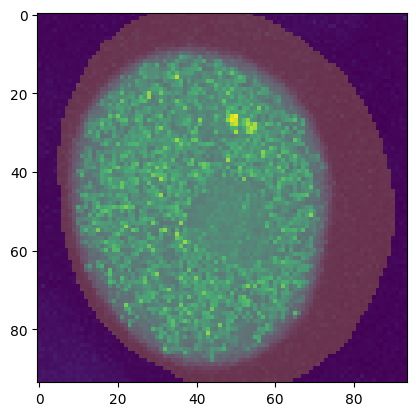

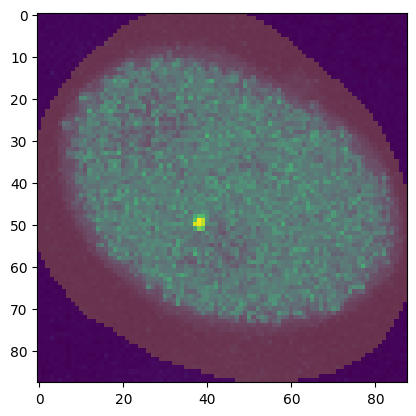

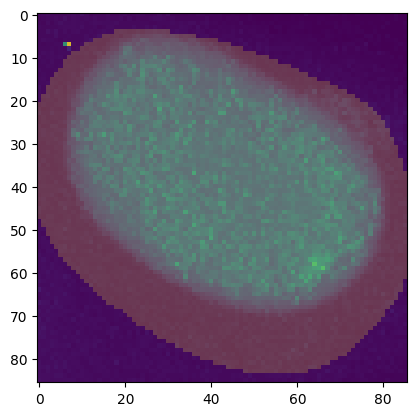

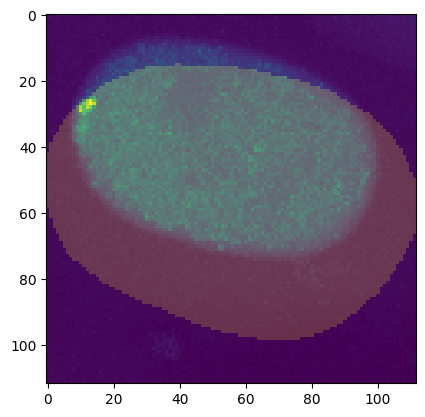

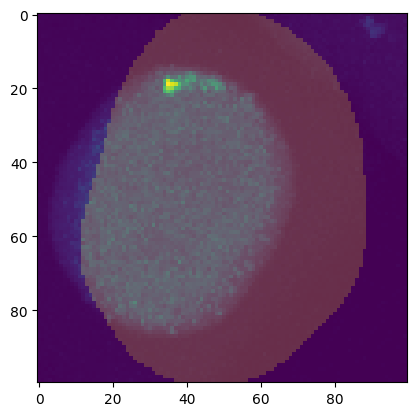

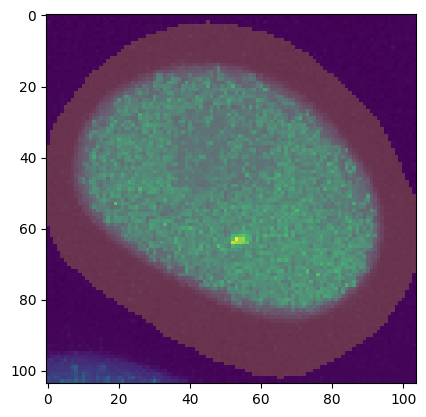

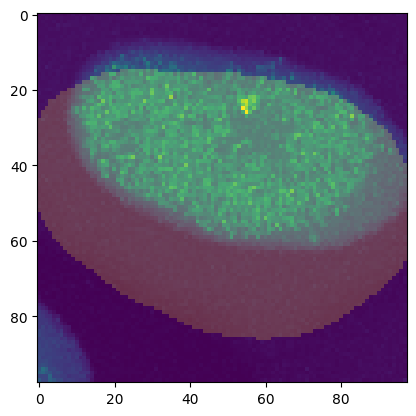

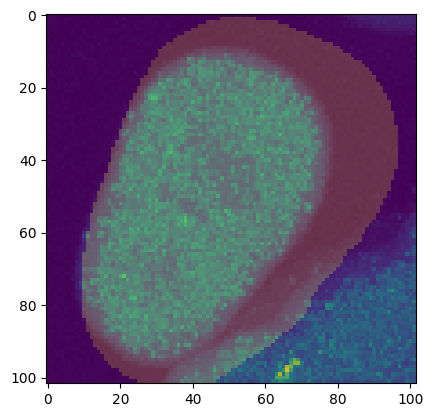

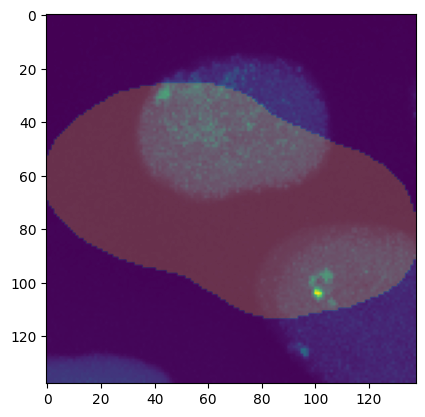

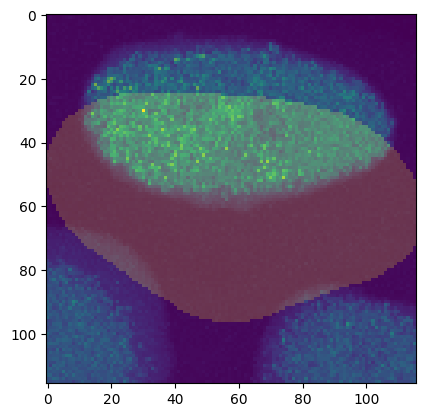

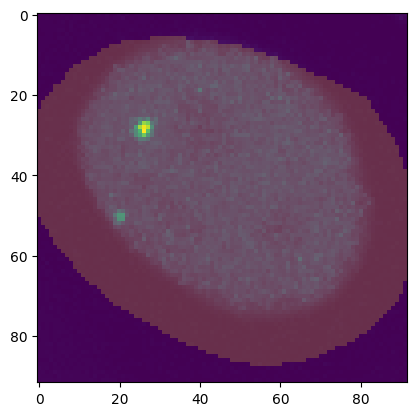

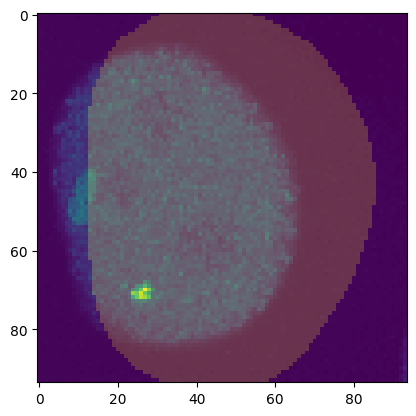

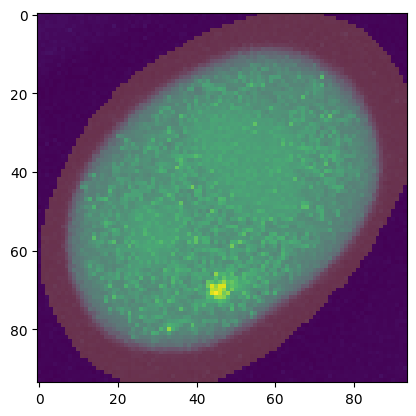

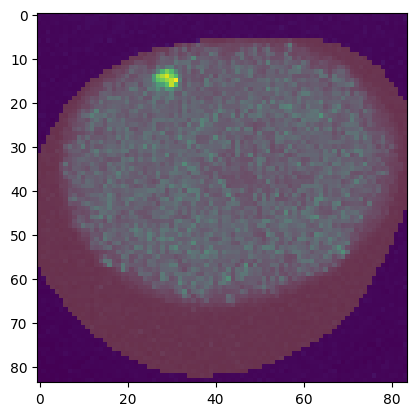

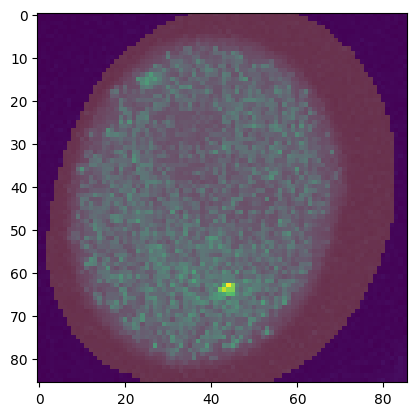

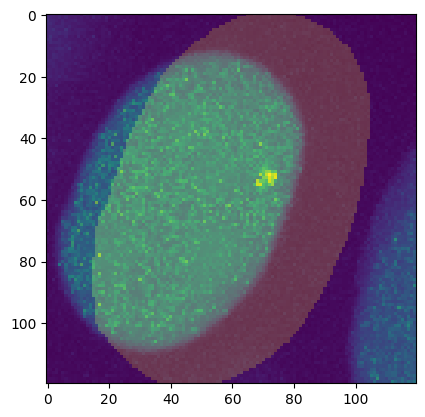

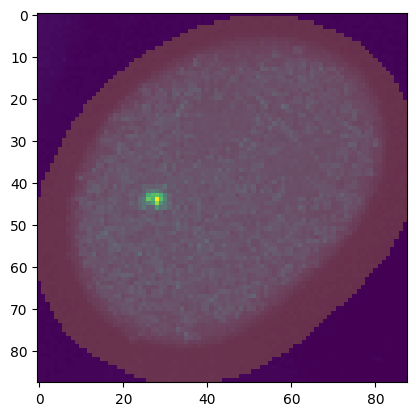

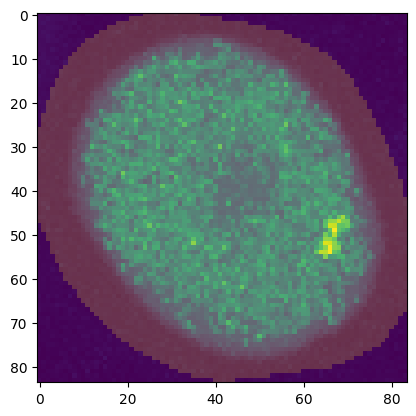

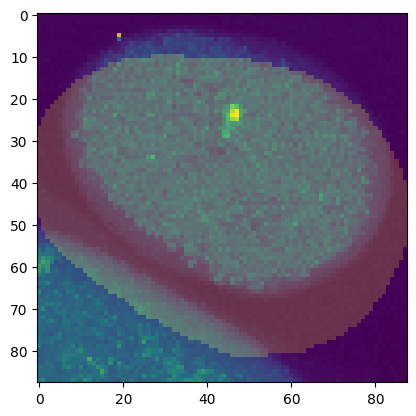

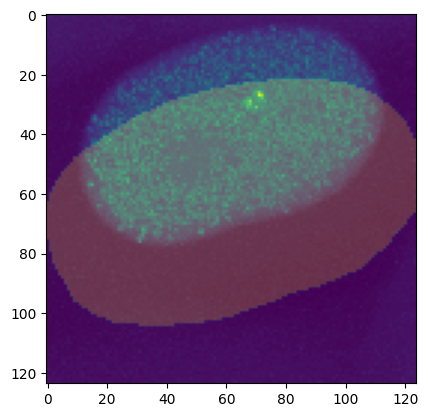

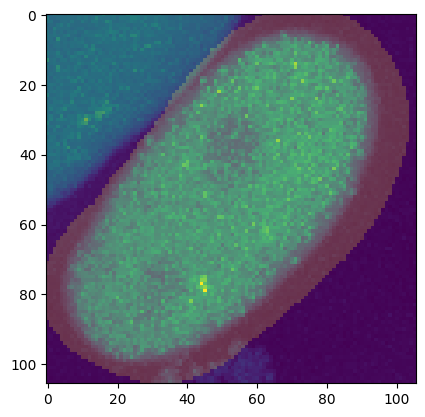

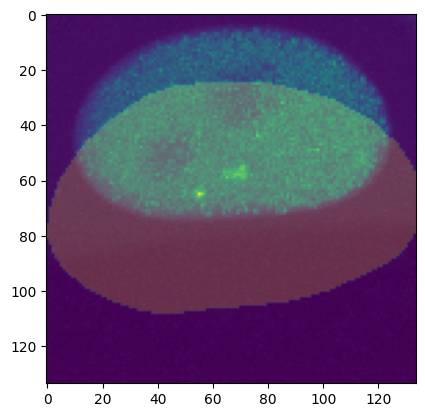

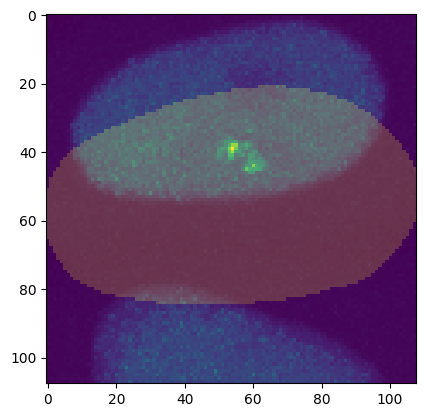

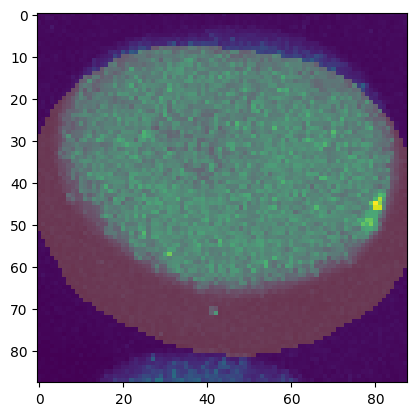

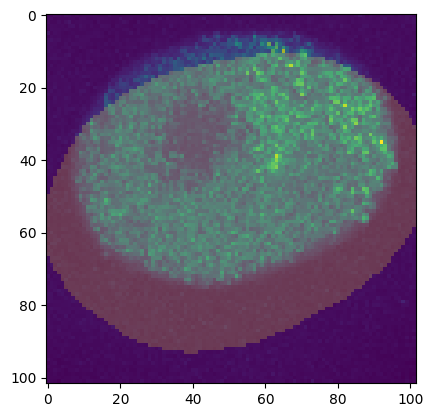

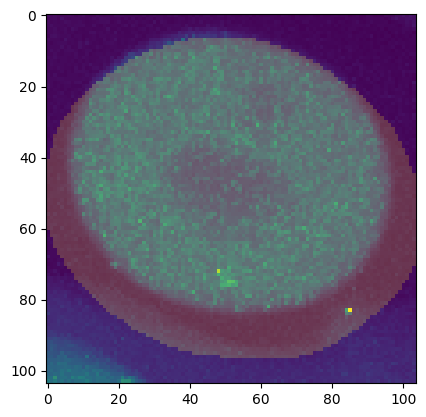

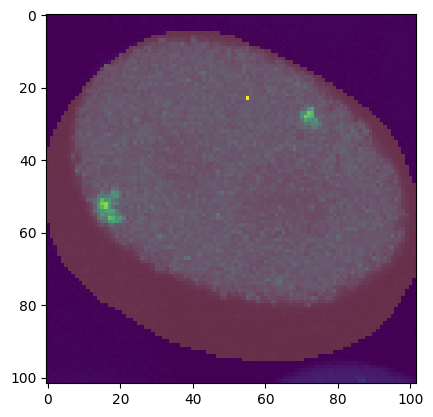

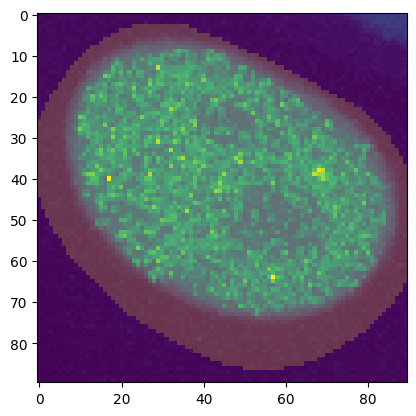

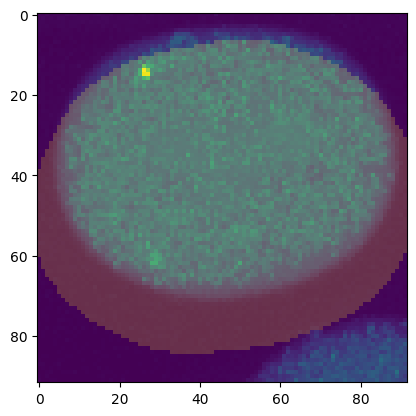

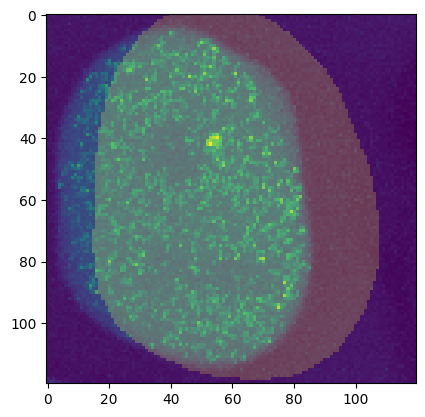

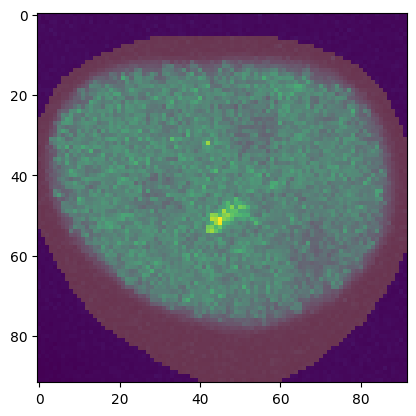

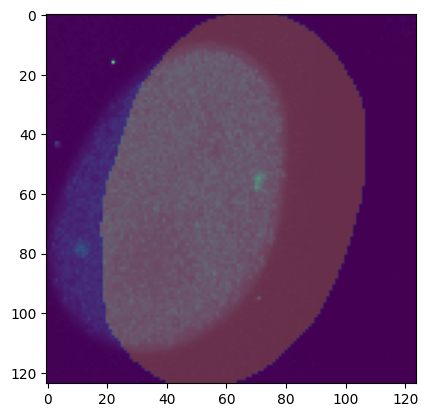

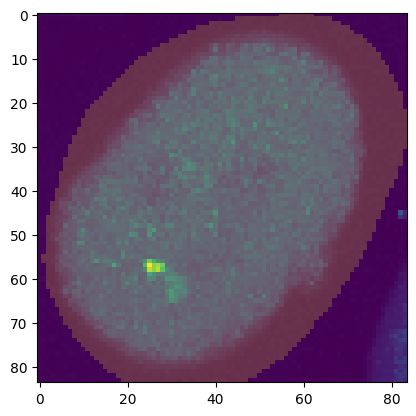

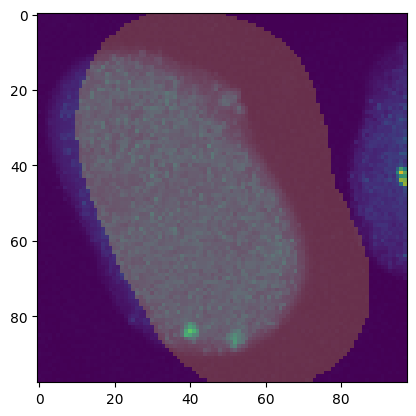

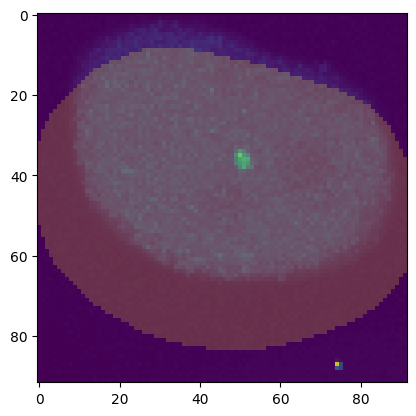

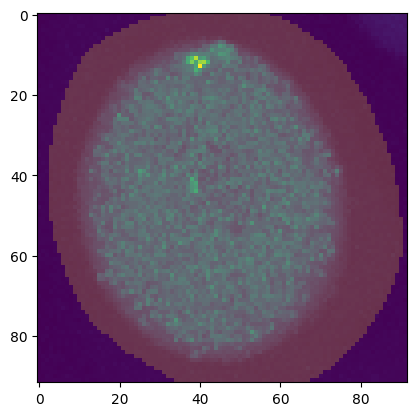

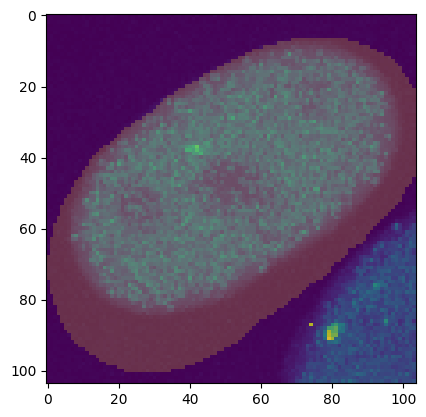

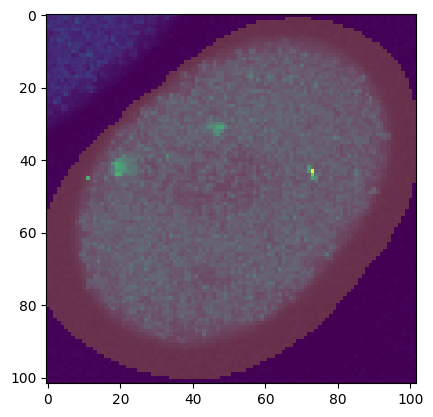

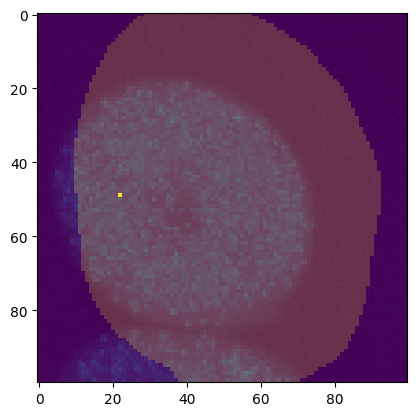

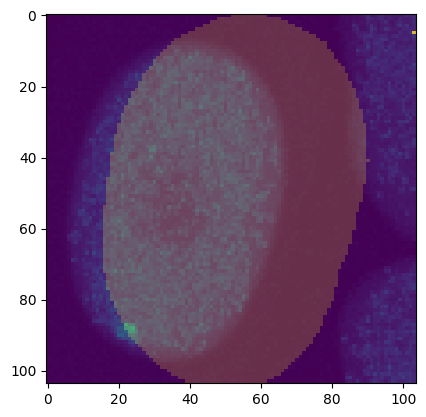

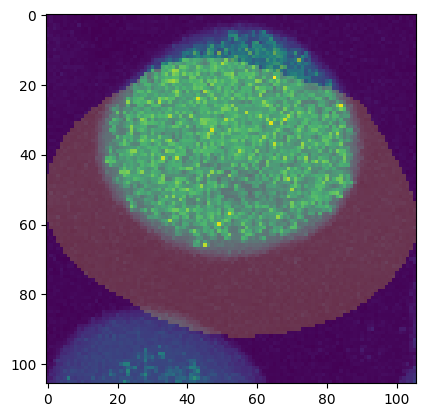

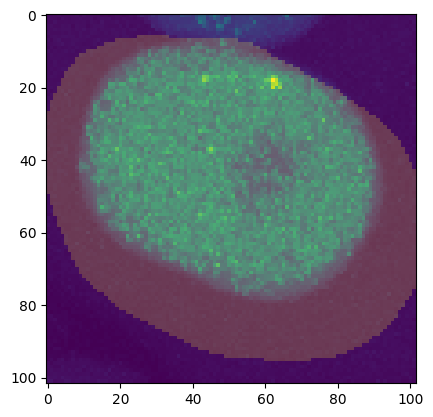

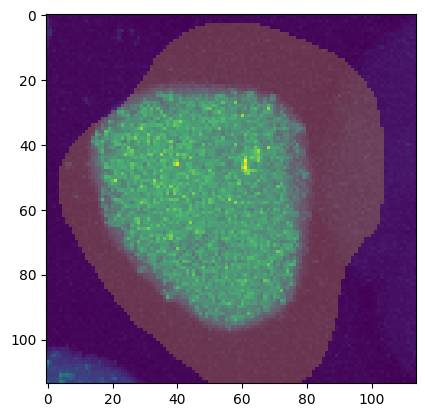

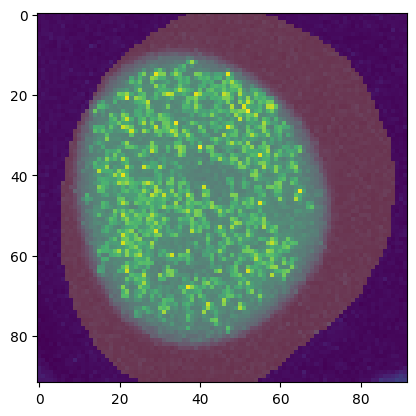

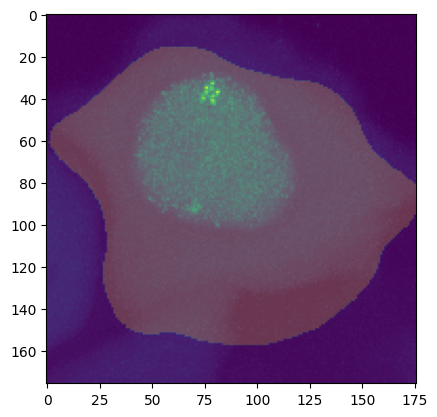

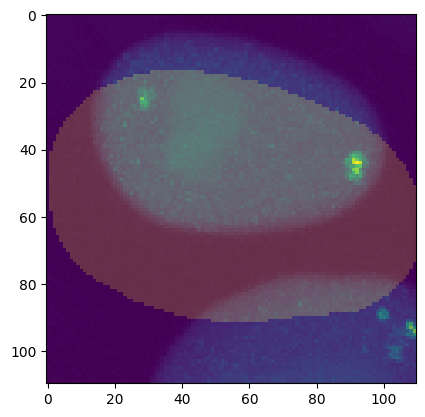

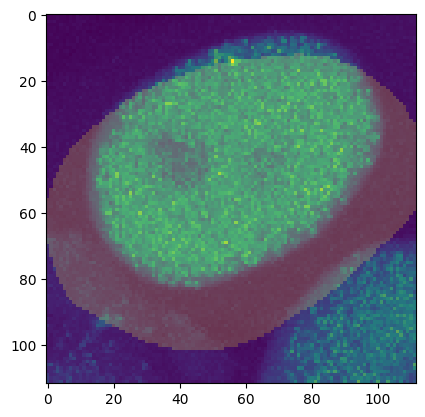

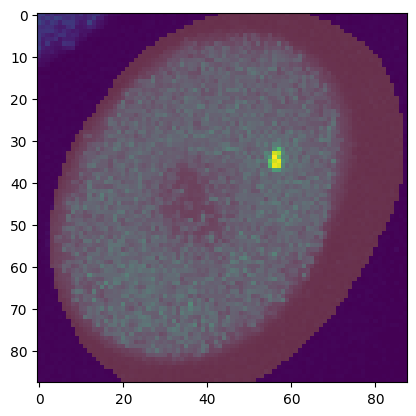

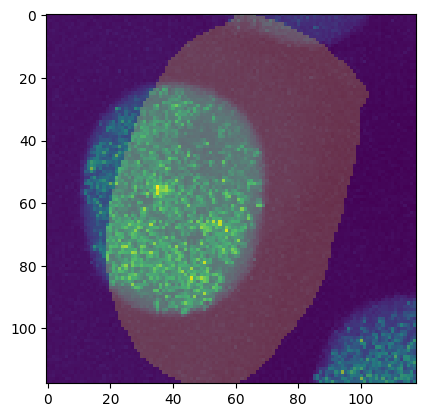

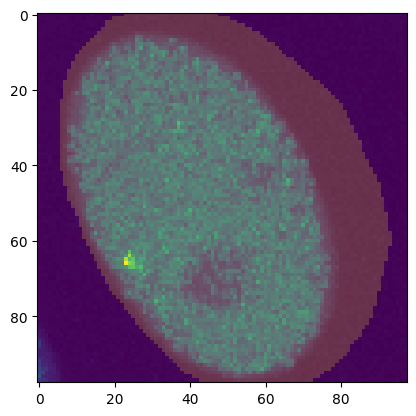

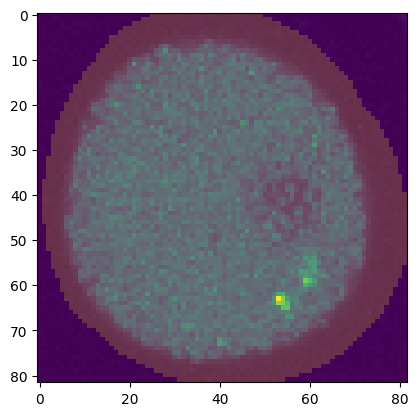

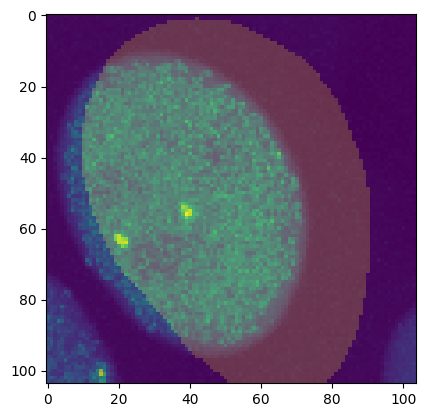

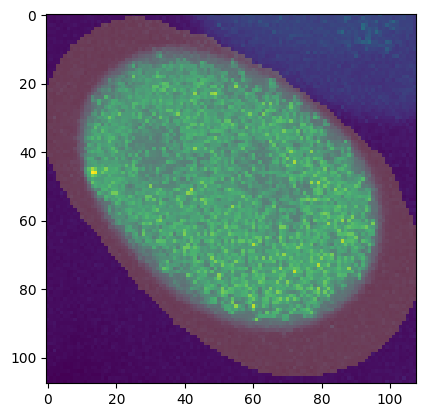

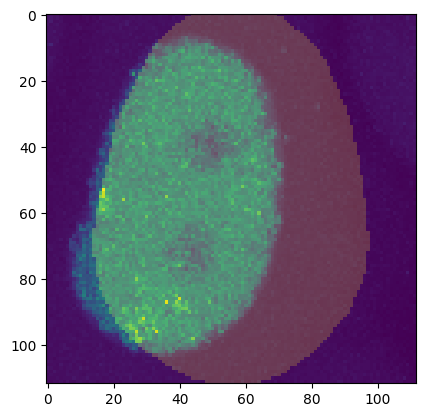

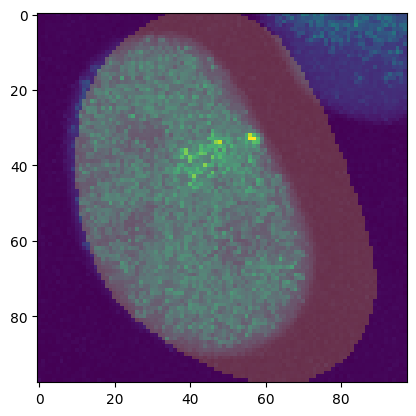

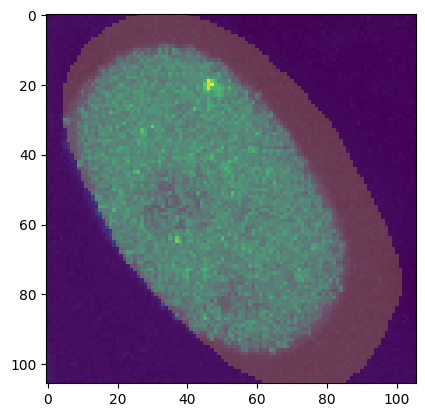

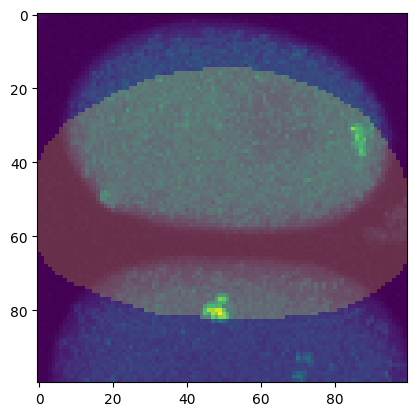

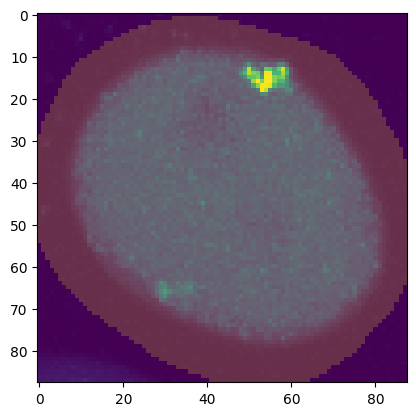

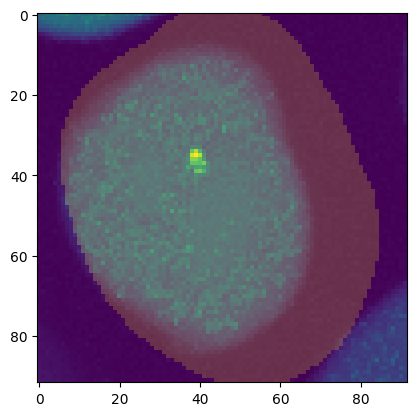

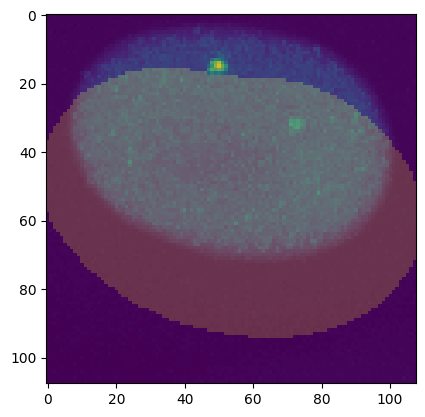

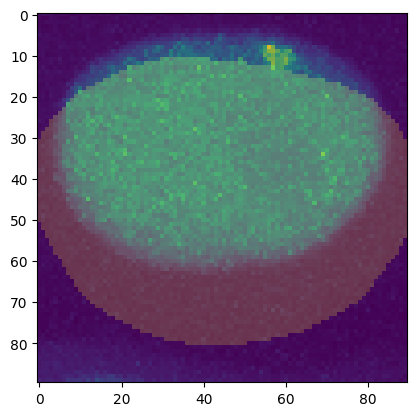

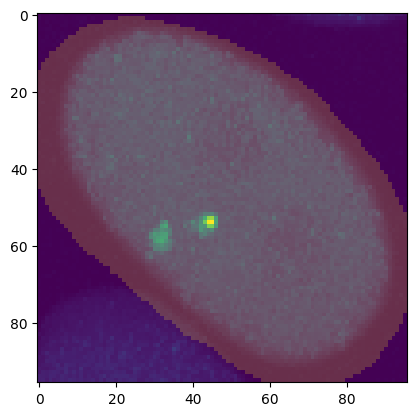

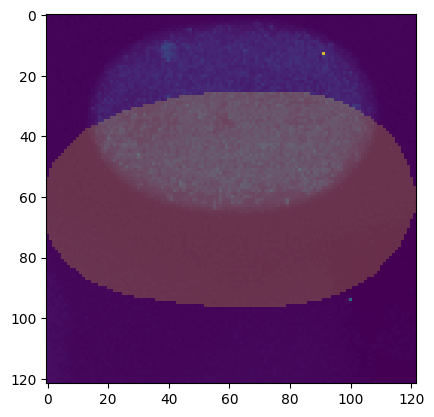

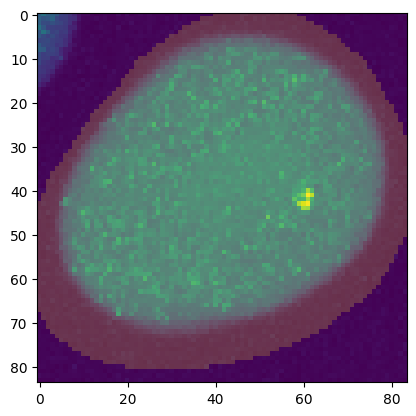

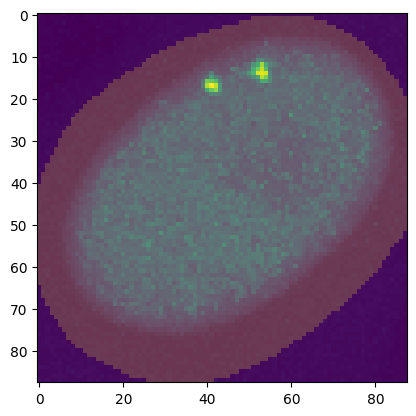

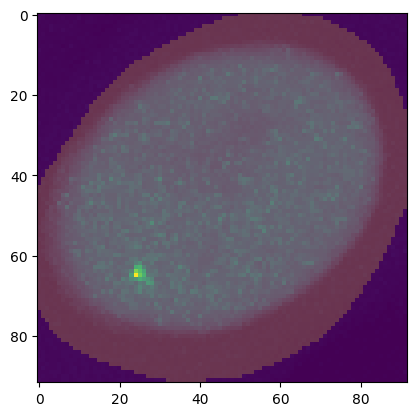

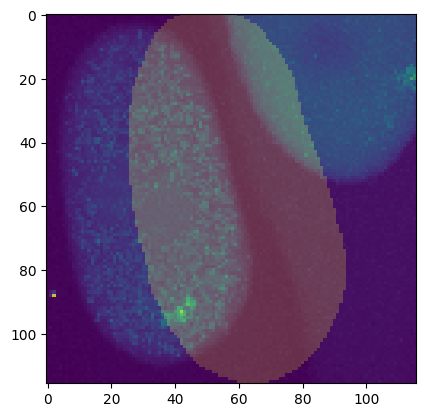

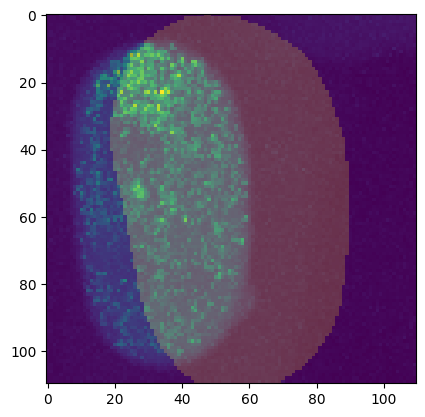

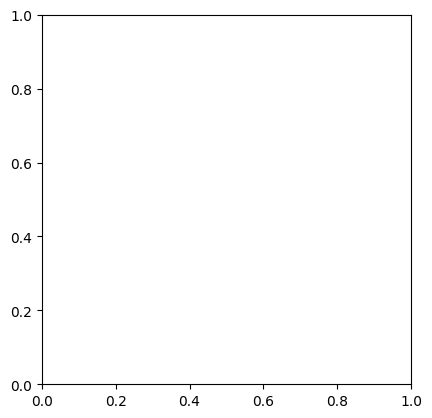

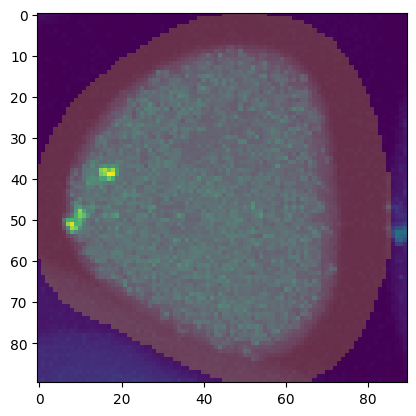

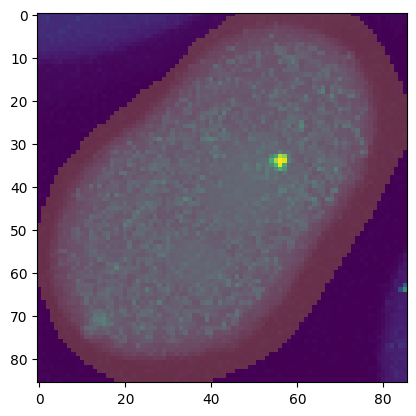

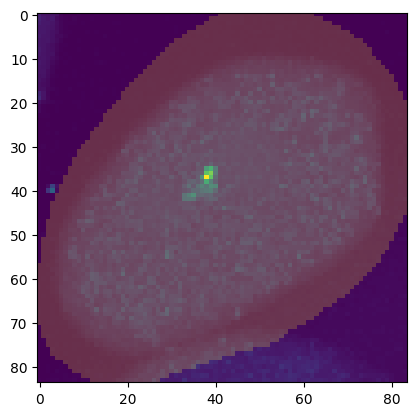

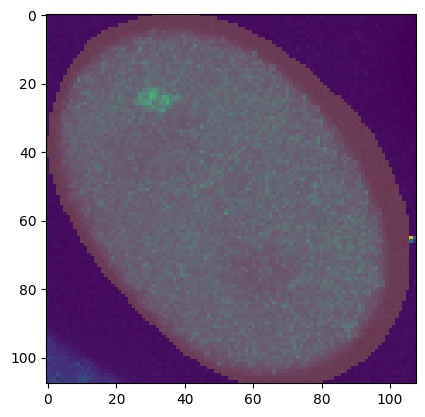

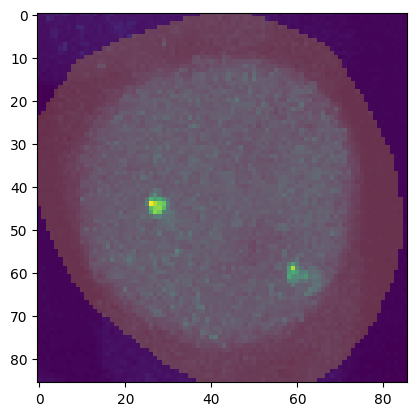

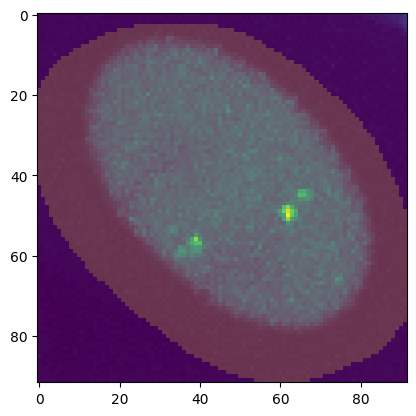

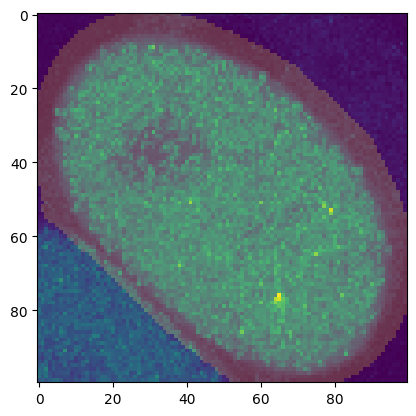

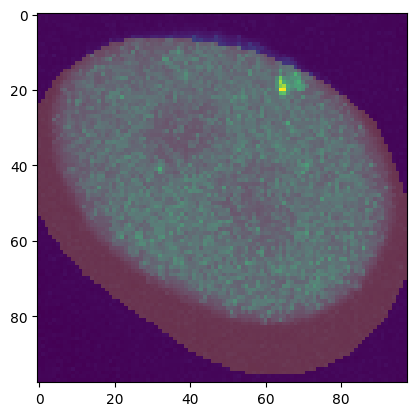

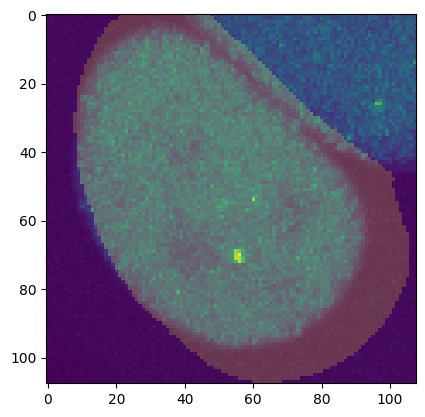

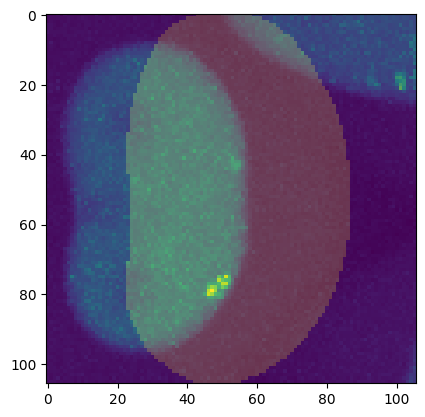

In [9]:


for baseFolder in basefolders:
    sessionNames = [os.path.join(baseFolder+'/'+i) for i in os.listdir(baseFolder) if midentifier in i and os.path.isdir(os.path.join(baseFolder,i))]
    sessionNames.sort()
    sessionName = sessionNames[0]
    nameKey = sessionName.split('/')[-2]

    imsQ = nameKey.split('_')[-1]
    thresholdFile = pd.read_csv(baseFolder+'/thresholds.csv', index_col=0)

    for fieldNumber in range(len(thresholdFile)): #[np.where(thresholdFile['cell']=='cell_'+str(cellNumber))[0][0]]:#
        print(fieldNumber)
        print('cell number :', thresholdFile['cell'][fieldNumber])
        selectedThreshold = float(thresholdFile['threshold'][fieldNumber])
        if selectedThreshold!=0:
            cellNumber = thresholdFile['cell'][fieldNumber]
            path_input = os.path.join(baseFolder,cellNumber)
            if os.path.exists(path_input):

                pathToTimeFramesCell = path_input+'/*.tif'

                sequenceCell = imr(pathToTimeFramesCell)
                mipSequenceCell = np.max(sequenceCell, axis=1)
                MaxTimePoint = sequenceCell.shape[0]

                print('path_in/out:', path_input)

                labeldf = pd.read_pickle(str(Path(baseFolder))+'LabelDF.pkl')
                tProj = np.max(mipSequenceCell, axis=0)
                maskpath = os.path.join(Path(baseFolder).parent, 'tProjections')+'/T_MAX_'+Path(baseFolder).name.replace('.','_')+'_cp_masks.png'
                maskImageAll = imread(maskpath)
                maskCell = getCellMask(cellNumber, labeldf, maskImageAll)



                ## Get a list of spots detected using the threshold specified in previous step
    #             images, spots_list, no_frames = getImagesAndSpotList(sequenceCellInput, selectedThreshold, voxelRadius, objectRadius, sampling=3)
                if len([os.path.join(path_input,i) for i in os.listdir(path_input) if cellNumber+'_spots_and_clusters' in i])!=0:

                    npzfilePath = [os.path.join(path_input,i) for i in os.listdir(path_input) if cellNumber+'_spots_and_clusters_27_May0.4' in i][0]
                    spots_file = np.load(npzfilePath, allow_pickle=True)['spotsFrame']

                    ## Remove unwanted spots
                    try:
                        spots_list = removeSpots(spots_file, maskCell)
                        savepath = os.path.join(path_input,imsQ+'_'+cellNumber+'corrected_spots_new_27May.npz')
                        np.savez(savepath, spots = spots_list)
                    except IndexError:
                        pass
                    try:
                        plt.figure()
                        plt.imshow(tProj)
                        plt.imshow(maskCell, alpha=0.2)

                    except ValueError:
                        pass
